In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import copy
import time

from scipy.stats import rankdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm_notebook as tqdm

from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from ranker_models import TransformerRanker, ExactRanker
from losses_metrics import spearmanr_torch, spearmanr_np
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)

In [2]:
path = 'data/'
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [4]:
dim = 128
config = transformers.configuration_distilbert.DistilBertConfig(
    dim=dim, hidden_dim=int(4*dim), n_heads=8, n_layers=2, dropout=0.0, attention_dropout=0.0)
config

{
  "activation": "gelu",
  "attention_dropout": 0.0,
  "dim": 128,
  "dropout": 0.0,
  "finetuning_task": null,
  "hidden_dim": 512,
  "initializer_range": 0.02,
  "is_decoder": false,
  "max_position_embeddings": 512,
  "n_heads": 8,
  "n_layers": 2,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torchscript": false,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [5]:
np.random.choice(3, 30)

array([2, 1, 1, 0, 0, 1, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 2, 0, 0, 1, 0, 2,
       1, 0, 2, 0, 2, 1, 2, 0])

In [6]:
class RankDataset(Dataset):
    def __init__(self, inputs, idxs):
        self.inputs = inputs[idxs].astype(np.float32)

    def __getitem__(self, idx):
        return self.inputs[idx]

    def __len__(self):
        return len(self.inputs)
    
class SeqDataset(Dataset):

    def __init__(self, seq_len, nb_sample=40000, dist=None):
        self.seq_len = seq_len
        self.nb_sample = nb_sample

    def __getitem__(self, index):
        rand_seq = np.random.uniform(-1, 1, self.seq_len).astype(np.float32)
        zipp_sort_ind = zip(np.argsort(rand_seq)[::-1], range(self.seq_len))

        ranks = [((y[1] + 1) / float(self.seq_len)) for y in sorted(zipp_sort_ind, key=lambda x: x[0])]

        return torch.FloatTensor(rand_seq), torch.FloatTensor(ranks)

    def __len__(self):
        return self.nb_sample

def collate_fn(batch):
    bs = len(batch)
    seqs = np.vstack(batch).T
    choices = np.random.choice(3, N_TARGETS)
    seqs[choices==1,:] = np.random.uniform(0, 1, size=(sum(choices==1), bs)).astype(np.float32)
    seqs[choices==2,:] = np.clip(
        seqs[choices==2,:] + np.random.normal(scale=1e-2, size=(sum(choices==2), bs)), 0, 1).astype(np.float32)
    ranks = np.zeros_like(seqs)
    for i in range(N_TARGETS): ranks[i,:] = (bs + 1 - rankdata(seqs[i,:])) / bs
    return torch.tensor(seqs), torch.tensor(ranks)

def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

In [7]:
num_workers = 10
bs = 64
lr = 1e-4
loss_fn = nn.L1Loss()
device = 'cuda'
n_epochs = 400
grad_accum = 1
weight_decay = 0.0
model_name = f'ranker_transformer_bs{bs}'
checkpoint_dir = 'checkpoints/'
early_stopping = 40
opt = optim.Adam

In [8]:
from utils.torch import to_device
def infer_batch(inputs, model, device, to_numpy=True):
    inputs = to_device(inputs, device)
    preds = model(*inputs)
    if to_numpy: preds = preds.cpu().detach().numpy().astype(np.float32)
    return preds

def infer(model, loader, checkpoint_file=None, device=torch.device('cuda')):

    print(f'Starting inference for model: {checkpoint_file}')
    n_obs = len(loader.dataset)
    batch_sz = loader.batch_size
    predictions, targets = np.zeros((n_obs, N_TARGETS)), np.zeros((n_obs, N_TARGETS))

    currently_deterministic = torch.backends.cudnn.deterministic
    torch.backends.cudnn.deterministic = True

    if checkpoint_file is not None:
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, (inputs, targs) in enumerate(tqdm(loader)):
            start_index = i * batch_sz
            end_index = min(start_index + batch_sz, n_obs)
            batch_preds = infer_batch(inputs, model, device)
            predictions[start_index:end_index, :] = batch_preds.T
            targets[start_index:end_index, :] = targs.T

    torch.backends.cudnn.deterministic = currently_deterministic

    return predictions, targets

Started at Mon Jan 20 19:59:02 2020
Starting inference for model: None


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Baseline: 0.02982712430749783


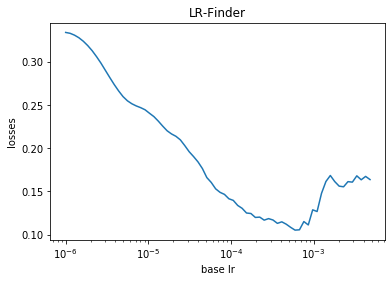

epoch 0: 	 Start training...



epoch 0/400 	 train : loss 0.18249 - MAE 0.18249
epoch 0: 	 Start validation...



epoch 0/400 	 valid : loss 0.059931 - MAE 0.059931
best model: epoch 0 - 0.059931
epoch 1: 	 Start training...



epoch 1/400 	 train : loss 0.059829 - MAE 0.059829
epoch 1: 	 Start validation...



epoch 1/400 	 valid : loss 0.042909 - MAE 0.042909
best model: epoch 1 - 0.042909
epoch 2: 	 Start training...



epoch 2/400 	 train : loss 0.04857 - MAE 0.04857
epoch 2: 	 Start validation...



epoch 2/400 	 valid : loss 0.040079 - MAE 0.040079
best model: epoch 2 - 0.040079
epoch 3: 	 Start training...



epoch 3/400 	 train : loss 0.046735 - MAE 0.046735
epoch 3: 	 Start validation...



epoch 3/400 	 valid : loss 0.036632 - MAE 0.036632
best model: epoch 3 - 0.036632
epoch 4: 	 Start training...



epoch 4/400 	 train : loss 0.041429 - MAE 0.041429
epoch 4: 	 Start validation...



epoch 4/400 	 valid : loss 0.026134 - MAE 0.026134
best model: epoch 4 - 0.026134
epoch 5: 	 Start training...



epoch 5/400 	 train : loss 0.028608 - MAE 0.028608
epoch 5: 	 Start validation...



epoch 5/400 	 valid : loss 0.023216 - MAE 0.023216
best model: epoch 5 - 0.023216
epoch 6: 	 Start training...



epoch 6/400 	 train : loss 0.02259 - MAE 0.02259
epoch 6: 	 Start validation...



epoch 6/400 	 valid : loss 0.016258 - MAE 0.016258
best model: epoch 6 - 0.016258
epoch 7: 	 Start training...



epoch 7/400 	 train : loss 0.019707 - MAE 0.019707
epoch 7: 	 Start validation...



epoch 7/400 	 valid : loss 0.016613 - MAE 0.016613
model not improved for 1 epochs
epoch 8: 	 Start training...



epoch 8/400 	 train : loss 0.013474 - MAE 0.013474
epoch 8: 	 Start validation...



epoch 8/400 	 valid : loss 0.010559 - MAE 0.010559
best model: epoch 8 - 0.010559
epoch 9: 	 Start training...



epoch 9/400 	 train : loss 0.012897 - MAE 0.012897
epoch 9: 	 Start validation...



epoch 9/400 	 valid : loss 0.011852 - MAE 0.011852
model not improved for 1 epochs
epoch 10: 	 Start training...



epoch 10/400 	 train : loss 0.010778 - MAE 0.010778
epoch 10: 	 Start validation...



epoch 10/400 	 valid : loss 0.010856 - MAE 0.010856
model not improved for 2 epochs
epoch 11: 	 Start training...



epoch 11/400 	 train : loss 0.010012 - MAE 0.010012
epoch 11: 	 Start validation...



epoch 11/400 	 valid : loss 0.0099076 - MAE 0.0099076
best model: epoch 11 - 0.0099076
epoch 12: 	 Start training...



epoch 12/400 	 train : loss 0.008937 - MAE 0.008937
epoch 12: 	 Start validation...



epoch 12/400 	 valid : loss 0.0073571 - MAE 0.0073571
best model: epoch 12 - 0.0073571
epoch 13: 	 Start training...



epoch 13/400 	 train : loss 0.0087196 - MAE 0.0087196
epoch 13: 	 Start validation...



epoch 13/400 	 valid : loss 0.0072388 - MAE 0.0072388
best model: epoch 13 - 0.0072388
epoch 14: 	 Start training...



epoch 14/400 	 train : loss 0.007825 - MAE 0.007825
epoch 14: 	 Start validation...



epoch 14/400 	 valid : loss 0.0087579 - MAE 0.0087579
model not improved for 1 epochs
epoch 15: 	 Start training...



epoch 15/400 	 train : loss 0.0069022 - MAE 0.0069022
epoch 15: 	 Start validation...



epoch 15/400 	 valid : loss 0.0080318 - MAE 0.0080318
model not improved for 2 epochs
epoch 16: 	 Start training...



epoch 16/400 	 train : loss 0.0086219 - MAE 0.0086219
epoch 16: 	 Start validation...



epoch 16/400 	 valid : loss 0.010962 - MAE 0.010962
model not improved for 3 epochs
epoch 17: 	 Start training...



epoch 17/400 	 train : loss 0.0076426 - MAE 0.0076426
epoch 17: 	 Start validation...



epoch 17/400 	 valid : loss 0.007723 - MAE 0.007723
model not improved for 4 epochs
epoch 18: 	 Start training...



epoch 18/400 	 train : loss 0.0086745 - MAE 0.0086745
epoch 18: 	 Start validation...



epoch 18/400 	 valid : loss 0.0053397 - MAE 0.0053397
best model: epoch 18 - 0.0053397
epoch 19: 	 Start training...



epoch 19/400 	 train : loss 0.0062351 - MAE 0.0062351
epoch 19: 	 Start validation...



epoch 19/400 	 valid : loss 0.0068933 - MAE 0.0068933
model not improved for 1 epochs
epoch 20: 	 Start training...



epoch 20/400 	 train : loss 0.0070113 - MAE 0.0070113
epoch 20: 	 Start validation...



epoch 20/400 	 valid : loss 0.0089043 - MAE 0.0089043
model not improved for 2 epochs
epoch 21: 	 Start training...



epoch 21/400 	 train : loss 0.0073725 - MAE 0.0073725
epoch 21: 	 Start validation...



epoch 21/400 	 valid : loss 0.0061274 - MAE 0.0061274
model not improved for 3 epochs
epoch 22: 	 Start training...



epoch 22/400 	 train : loss 0.0069415 - MAE 0.0069415
epoch 22: 	 Start validation...



epoch 22/400 	 valid : loss 0.0064712 - MAE 0.0064712
model not improved for 4 epochs
epoch 23: 	 Start training...



epoch 23/400 	 train : loss 0.0060767 - MAE 0.0060767
epoch 23: 	 Start validation...



epoch 23/400 	 valid : loss 0.0054244 - MAE 0.0054244
model not improved for 5 epochs
epoch 24: 	 Start training...



epoch 24/400 	 train : loss 0.0055949 - MAE 0.0055949
epoch 24: 	 Start validation...



epoch 24/400 	 valid : loss 0.0053877 - MAE 0.0053877
model not improved for 6 epochs
epoch 25: 	 Start training...



epoch 25/400 	 train : loss 0.0050588 - MAE 0.0050588
epoch 25: 	 Start validation...



epoch 25/400 	 valid : loss 0.0043569 - MAE 0.0043569
best model: epoch 25 - 0.0043569
epoch 26: 	 Start training...



epoch 26/400 	 train : loss 0.0049583 - MAE 0.0049583
epoch 26: 	 Start validation...



epoch 26/400 	 valid : loss 0.0053663 - MAE 0.0053663
model not improved for 1 epochs
epoch 27: 	 Start training...



epoch 27/400 	 train : loss 0.006368 - MAE 0.006368
epoch 27: 	 Start validation...



epoch 27/400 	 valid : loss 0.0053265 - MAE 0.0053265
model not improved for 2 epochs
epoch 28: 	 Start training...



epoch 28/400 	 train : loss 0.004566 - MAE 0.004566
epoch 28: 	 Start validation...



epoch 28/400 	 valid : loss 0.0057431 - MAE 0.0057431
model not improved for 3 epochs
epoch 29: 	 Start training...



epoch 29/400 	 train : loss 0.0056874 - MAE 0.0056874
epoch 29: 	 Start validation...



epoch 29/400 	 valid : loss 0.0039815 - MAE 0.0039815
best model: epoch 29 - 0.0039815
epoch 30: 	 Start training...



epoch 30/400 	 train : loss 0.0053074 - MAE 0.0053074
epoch 30: 	 Start validation...



epoch 30/400 	 valid : loss 0.0090094 - MAE 0.0090094
model not improved for 1 epochs
epoch 31: 	 Start training...



epoch 31/400 	 train : loss 0.0064712 - MAE 0.0064712
epoch 31: 	 Start validation...



epoch 31/400 	 valid : loss 0.005971 - MAE 0.005971
model not improved for 2 epochs
epoch 32: 	 Start training...



epoch 32/400 	 train : loss 0.0051602 - MAE 0.0051602
epoch 32: 	 Start validation...



epoch 32/400 	 valid : loss 0.0050048 - MAE 0.0050048
model not improved for 3 epochs
epoch 33: 	 Start training...



epoch 33/400 	 train : loss 0.00591 - MAE 0.00591
epoch 33: 	 Start validation...



epoch 33/400 	 valid : loss 0.0056072 - MAE 0.0056072
model not improved for 4 epochs
epoch 34: 	 Start training...



epoch 34/400 	 train : loss 0.0047198 - MAE 0.0047198
epoch 34: 	 Start validation...



epoch 34/400 	 valid : loss 0.0067096 - MAE 0.0067096
model not improved for 5 epochs
epoch 35: 	 Start training...



epoch 35/400 	 train : loss 0.0052884 - MAE 0.0052884
epoch 35: 	 Start validation...



epoch 35/400 	 valid : loss 0.0041816 - MAE 0.0041816
model not improved for 6 epochs
epoch 36: 	 Start training...



epoch 36/400 	 train : loss 0.0048919 - MAE 0.0048919
epoch 36: 	 Start validation...



epoch 36/400 	 valid : loss 0.0044212 - MAE 0.0044212
model not improved for 7 epochs
epoch 37: 	 Start training...



epoch 37/400 	 train : loss 0.0048917 - MAE 0.0048917
epoch 37: 	 Start validation...



epoch 37/400 	 valid : loss 0.0053759 - MAE 0.0053759
model not improved for 8 epochs
epoch 38: 	 Start training...



epoch 38/400 	 train : loss 0.0047794 - MAE 0.0047794
epoch 38: 	 Start validation...



epoch 38/400 	 valid : loss 0.0063842 - MAE 0.0063842
model not improved for 9 epochs
epoch 39: 	 Start training...



epoch 39/400 	 train : loss 0.0062475 - MAE 0.0062475
epoch 39: 	 Start validation...



epoch 39/400 	 valid : loss 0.004196 - MAE 0.004196
model not improved for 10 epochs
epoch 40: 	 Start training...



epoch 40/400 	 train : loss 0.003525 - MAE 0.003525
epoch 40: 	 Start validation...



epoch 40/400 	 valid : loss 0.0032924 - MAE 0.0032924
best model: epoch 40 - 0.0032924
epoch 41: 	 Start training...



epoch 41/400 	 train : loss 0.0031048 - MAE 0.0031048
epoch 41: 	 Start validation...



epoch 41/400 	 valid : loss 0.0032913 - MAE 0.0032913
best model: epoch 41 - 0.0032913
epoch 42: 	 Start training...



epoch 42/400 	 train : loss 0.0030581 - MAE 0.0030581
epoch 42: 	 Start validation...



epoch 42/400 	 valid : loss 0.0029815 - MAE 0.0029815
best model: epoch 42 - 0.0029815
epoch 43: 	 Start training...



epoch 43/400 	 train : loss 0.0028288 - MAE 0.0028288
epoch 43: 	 Start validation...



epoch 43/400 	 valid : loss 0.0027658 - MAE 0.0027658
best model: epoch 43 - 0.0027658
epoch 44: 	 Start training...



epoch 44/400 	 train : loss 0.0031098 - MAE 0.0031098
epoch 44: 	 Start validation...



epoch 44/400 	 valid : loss 0.0032288 - MAE 0.0032288
model not improved for 1 epochs
epoch 45: 	 Start training...



epoch 45/400 	 train : loss 0.0032214 - MAE 0.0032214
epoch 45: 	 Start validation...



epoch 45/400 	 valid : loss 0.002855 - MAE 0.002855
model not improved for 2 epochs
epoch 46: 	 Start training...



epoch 46/400 	 train : loss 0.0029105 - MAE 0.0029105
epoch 46: 	 Start validation...



epoch 46/400 	 valid : loss 0.0031223 - MAE 0.0031223
model not improved for 3 epochs
epoch 47: 	 Start training...



epoch 47/400 	 train : loss 0.0027485 - MAE 0.0027485
epoch 47: 	 Start validation...



epoch 47/400 	 valid : loss 0.0030028 - MAE 0.0030028
model not improved for 4 epochs
epoch 48: 	 Start training...



epoch 48/400 	 train : loss 0.0028298 - MAE 0.0028298
epoch 48: 	 Start validation...



epoch 48/400 	 valid : loss 0.0026434 - MAE 0.0026434
best model: epoch 48 - 0.0026434
epoch 49: 	 Start training...



epoch 49/400 	 train : loss 0.003171 - MAE 0.003171
epoch 49: 	 Start validation...



epoch 49/400 	 valid : loss 0.0039712 - MAE 0.0039712
model not improved for 1 epochs
epoch 50: 	 Start training...



epoch 50/400 	 train : loss 0.0030444 - MAE 0.0030444
epoch 50: 	 Start validation...



epoch 50/400 	 valid : loss 0.0035094 - MAE 0.0035094
model not improved for 2 epochs
epoch 51: 	 Start training...



epoch 51/400 	 train : loss 0.0028645 - MAE 0.0028645
epoch 51: 	 Start validation...



epoch 51/400 	 valid : loss 0.0026328 - MAE 0.0026328
best model: epoch 51 - 0.0026328
epoch 52: 	 Start training...



epoch 52/400 	 train : loss 0.0026965 - MAE 0.0026965
epoch 52: 	 Start validation...



epoch 52/400 	 valid : loss 0.0027382 - MAE 0.0027382
model not improved for 1 epochs
epoch 53: 	 Start training...



epoch 53/400 	 train : loss 0.0029031 - MAE 0.0029031
epoch 53: 	 Start validation...



epoch 53/400 	 valid : loss 0.0027523 - MAE 0.0027523
model not improved for 2 epochs
epoch 54: 	 Start training...



epoch 54/400 	 train : loss 0.0032073 - MAE 0.0032073
epoch 54: 	 Start validation...



epoch 54/400 	 valid : loss 0.0040409 - MAE 0.0040409
model not improved for 3 epochs
epoch 55: 	 Start training...



epoch 55/400 	 train : loss 0.002822 - MAE 0.002822
epoch 55: 	 Start validation...



epoch 55/400 	 valid : loss 0.0026383 - MAE 0.0026383
model not improved for 4 epochs
epoch 56: 	 Start training...



epoch 56/400 	 train : loss 0.0030013 - MAE 0.0030013
epoch 56: 	 Start validation...



epoch 56/400 	 valid : loss 0.0032629 - MAE 0.0032629
model not improved for 5 epochs
epoch 57: 	 Start training...



epoch 57/400 	 train : loss 0.0028975 - MAE 0.0028975
epoch 57: 	 Start validation...



epoch 57/400 	 valid : loss 0.0027292 - MAE 0.0027292
model not improved for 6 epochs
epoch 58: 	 Start training...



epoch 58/400 	 train : loss 0.0027674 - MAE 0.0027674
epoch 58: 	 Start validation...



epoch 58/400 	 valid : loss 0.0039584 - MAE 0.0039584
model not improved for 7 epochs
epoch 59: 	 Start training...



epoch 59/400 	 train : loss 0.0030199 - MAE 0.0030199
epoch 59: 	 Start validation...



epoch 59/400 	 valid : loss 0.0033237 - MAE 0.0033237
model not improved for 8 epochs
epoch 60: 	 Start training...



epoch 60/400 	 train : loss 0.0030939 - MAE 0.0030939
epoch 60: 	 Start validation...



epoch 60/400 	 valid : loss 0.0029523 - MAE 0.0029523
model not improved for 9 epochs
epoch 61: 	 Start training...



epoch 61/400 	 train : loss 0.0026918 - MAE 0.0026918
epoch 61: 	 Start validation...



epoch 61/400 	 valid : loss 0.0027673 - MAE 0.0027673
model not improved for 10 epochs
epoch 62: 	 Start training...



epoch 62/400 	 train : loss 0.0026136 - MAE 0.0026136
epoch 62: 	 Start validation...



epoch 62/400 	 valid : loss 0.0022847 - MAE 0.0022847
best model: epoch 62 - 0.0022847
epoch 63: 	 Start training...



epoch 63/400 	 train : loss 0.0030819 - MAE 0.0030819
epoch 63: 	 Start validation...



epoch 63/400 	 valid : loss 0.0039641 - MAE 0.0039641
model not improved for 1 epochs
epoch 64: 	 Start training...



epoch 64/400 	 train : loss 0.0025449 - MAE 0.0025449
epoch 64: 	 Start validation...



epoch 64/400 	 valid : loss 0.0028331 - MAE 0.0028331
model not improved for 2 epochs
epoch 65: 	 Start training...



epoch 65/400 	 train : loss 0.0027451 - MAE 0.0027451
epoch 65: 	 Start validation...



epoch 65/400 	 valid : loss 0.0023583 - MAE 0.0023583
model not improved for 3 epochs
epoch 66: 	 Start training...



epoch 66/400 	 train : loss 0.0024263 - MAE 0.0024263
epoch 66: 	 Start validation...



epoch 66/400 	 valid : loss 0.0034751 - MAE 0.0034751
model not improved for 4 epochs
epoch 67: 	 Start training...



epoch 67/400 	 train : loss 0.0025244 - MAE 0.0025244
epoch 67: 	 Start validation...



epoch 67/400 	 valid : loss 0.0035549 - MAE 0.0035549
model not improved for 5 epochs
epoch 68: 	 Start training...



epoch 68/400 	 train : loss 0.0024385 - MAE 0.0024385
epoch 68: 	 Start validation...



epoch 68/400 	 valid : loss 0.0043189 - MAE 0.0043189
model not improved for 6 epochs
epoch 69: 	 Start training...



epoch 69/400 	 train : loss 0.0028711 - MAE 0.0028711
epoch 69: 	 Start validation...



epoch 69/400 	 valid : loss 0.002445 - MAE 0.002445
model not improved for 7 epochs
epoch 70: 	 Start training...



epoch 70/400 	 train : loss 0.0022646 - MAE 0.0022646
epoch 70: 	 Start validation...



epoch 70/400 	 valid : loss 0.0021864 - MAE 0.0021864
best model: epoch 70 - 0.0021864
epoch 71: 	 Start training...



epoch 71/400 	 train : loss 0.0022434 - MAE 0.0022434
epoch 71: 	 Start validation...



epoch 71/400 	 valid : loss 0.0024684 - MAE 0.0024684
model not improved for 1 epochs
epoch 72: 	 Start training...



epoch 72/400 	 train : loss 0.0029439 - MAE 0.0029439
epoch 72: 	 Start validation...



epoch 72/400 	 valid : loss 0.0026165 - MAE 0.0026165
model not improved for 2 epochs
epoch 73: 	 Start training...



epoch 73/400 	 train : loss 0.0023638 - MAE 0.0023638
epoch 73: 	 Start validation...



epoch 73/400 	 valid : loss 0.0023286 - MAE 0.0023286
model not improved for 3 epochs
epoch 74: 	 Start training...



epoch 74/400 	 train : loss 0.0031637 - MAE 0.0031637
epoch 74: 	 Start validation...



epoch 74/400 	 valid : loss 0.0026622 - MAE 0.0026622
model not improved for 4 epochs
epoch 75: 	 Start training...



epoch 75/400 	 train : loss 0.0024905 - MAE 0.0024905
epoch 75: 	 Start validation...



epoch 75/400 	 valid : loss 0.001974 - MAE 0.001974
best model: epoch 75 - 0.001974
epoch 76: 	 Start training...



epoch 76/400 	 train : loss 0.0027222 - MAE 0.0027222
epoch 76: 	 Start validation...



epoch 76/400 	 valid : loss 0.0035911 - MAE 0.0035911
model not improved for 1 epochs
epoch 77: 	 Start training...



epoch 77/400 	 train : loss 0.0026046 - MAE 0.0026046
epoch 77: 	 Start validation...



epoch 77/400 	 valid : loss 0.0021767 - MAE 0.0021767
model not improved for 2 epochs
epoch 78: 	 Start training...



epoch 78/400 	 train : loss 0.0026391 - MAE 0.0026391
epoch 78: 	 Start validation...



epoch 78/400 	 valid : loss 0.0033285 - MAE 0.0033285
model not improved for 3 epochs
epoch 79: 	 Start training...



epoch 79/400 	 train : loss 0.0024555 - MAE 0.0024555
epoch 79: 	 Start validation...



epoch 79/400 	 valid : loss 0.0029681 - MAE 0.0029681
model not improved for 4 epochs
epoch 80: 	 Start training...



epoch 80/400 	 train : loss 0.0018714 - MAE 0.0018714
epoch 80: 	 Start validation...



epoch 80/400 	 valid : loss 0.0016439 - MAE 0.0016439
best model: epoch 80 - 0.0016439
epoch 81: 	 Start training...



epoch 81/400 	 train : loss 0.0016267 - MAE 0.0016267
epoch 81: 	 Start validation...



epoch 81/400 	 valid : loss 0.0017277 - MAE 0.0017277
model not improved for 1 epochs
epoch 82: 	 Start training...



epoch 82/400 	 train : loss 0.0016213 - MAE 0.0016213
epoch 82: 	 Start validation...



epoch 82/400 	 valid : loss 0.0016126 - MAE 0.0016126
best model: epoch 82 - 0.0016126
epoch 83: 	 Start training...



epoch 83/400 	 train : loss 0.0015905 - MAE 0.0015905
epoch 83: 	 Start validation...



epoch 83/400 	 valid : loss 0.0016346 - MAE 0.0016346
model not improved for 1 epochs
epoch 84: 	 Start training...



epoch 84/400 	 train : loss 0.0016696 - MAE 0.0016696
epoch 84: 	 Start validation...



epoch 84/400 	 valid : loss 0.0015597 - MAE 0.0015597
best model: epoch 84 - 0.0015597
epoch 85: 	 Start training...



epoch 85/400 	 train : loss 0.0015264 - MAE 0.0015264
epoch 85: 	 Start validation...



epoch 85/400 	 valid : loss 0.0014619 - MAE 0.0014619
best model: epoch 85 - 0.0014619
epoch 86: 	 Start training...



epoch 86/400 	 train : loss 0.0016656 - MAE 0.0016656
epoch 86: 	 Start validation...



epoch 86/400 	 valid : loss 0.0014891 - MAE 0.0014891
model not improved for 1 epochs
epoch 87: 	 Start training...



epoch 87/400 	 train : loss 0.0017008 - MAE 0.0017008
epoch 87: 	 Start validation...



epoch 87/400 	 valid : loss 0.0016305 - MAE 0.0016305
model not improved for 2 epochs
epoch 88: 	 Start training...



epoch 88/400 	 train : loss 0.0016193 - MAE 0.0016193
epoch 88: 	 Start validation...



epoch 88/400 	 valid : loss 0.0016151 - MAE 0.0016151
model not improved for 3 epochs
epoch 89: 	 Start training...



epoch 89/400 	 train : loss 0.0016441 - MAE 0.0016441
epoch 89: 	 Start validation...



epoch 89/400 	 valid : loss 0.0016981 - MAE 0.0016981
model not improved for 4 epochs
epoch 90: 	 Start training...



epoch 90/400 	 train : loss 0.0017058 - MAE 0.0017058
epoch 90: 	 Start validation...



epoch 90/400 	 valid : loss 0.0016518 - MAE 0.0016518
model not improved for 5 epochs
epoch 91: 	 Start training...



epoch 91/400 	 train : loss 0.0016607 - MAE 0.0016607
epoch 91: 	 Start validation...



epoch 91/400 	 valid : loss 0.0016109 - MAE 0.0016109
model not improved for 6 epochs
epoch 92: 	 Start training...



epoch 92/400 	 train : loss 0.001693 - MAE 0.001693
epoch 92: 	 Start validation...



epoch 92/400 	 valid : loss 0.0016385 - MAE 0.0016385
model not improved for 7 epochs
epoch 93: 	 Start training...



epoch 93/400 	 train : loss 0.0015201 - MAE 0.0015201
epoch 93: 	 Start validation...



epoch 93/400 	 valid : loss 0.0013439 - MAE 0.0013439
best model: epoch 93 - 0.0013439
epoch 94: 	 Start training...



epoch 94/400 	 train : loss 0.0016021 - MAE 0.0016021
epoch 94: 	 Start validation...



epoch 94/400 	 valid : loss 0.0013531 - MAE 0.0013531
model not improved for 1 epochs
epoch 95: 	 Start training...



epoch 95/400 	 train : loss 0.0018836 - MAE 0.0018836
epoch 95: 	 Start validation...



epoch 95/400 	 valid : loss 0.0017851 - MAE 0.0017851
model not improved for 2 epochs
epoch 96: 	 Start training...



epoch 96/400 	 train : loss 0.0016227 - MAE 0.0016227
epoch 96: 	 Start validation...



epoch 96/400 	 valid : loss 0.0014153 - MAE 0.0014153
model not improved for 3 epochs
epoch 97: 	 Start training...



epoch 97/400 	 train : loss 0.0015915 - MAE 0.0015915
epoch 97: 	 Start validation...



epoch 97/400 	 valid : loss 0.0014912 - MAE 0.0014912
model not improved for 4 epochs
epoch 98: 	 Start training...



epoch 98/400 	 train : loss 0.0014104 - MAE 0.0014104
epoch 98: 	 Start validation...



epoch 98/400 	 valid : loss 0.0013682 - MAE 0.0013682
model not improved for 5 epochs
epoch 99: 	 Start training...



epoch 99/400 	 train : loss 0.0015422 - MAE 0.0015422
epoch 99: 	 Start validation...



epoch 99/400 	 valid : loss 0.0018189 - MAE 0.0018189
model not improved for 6 epochs
epoch 100: 	 Start training...



epoch 100/400 	 train : loss 0.0015565 - MAE 0.0015565
epoch 100: 	 Start validation...



epoch 100/400 	 valid : loss 0.0015371 - MAE 0.0015371
model not improved for 7 epochs
epoch 101: 	 Start training...



epoch 101/400 	 train : loss 0.0014587 - MAE 0.0014587
epoch 101: 	 Start validation...



epoch 101/400 	 valid : loss 0.0015983 - MAE 0.0015983
model not improved for 8 epochs
epoch 102: 	 Start training...



epoch 102/400 	 train : loss 0.0015207 - MAE 0.0015207
epoch 102: 	 Start validation...



epoch 102/400 	 valid : loss 0.0022177 - MAE 0.0022177
model not improved for 9 epochs
epoch 103: 	 Start training...



epoch 103/400 	 train : loss 0.0016219 - MAE 0.0016219
epoch 103: 	 Start validation...



epoch 103/400 	 valid : loss 0.0014617 - MAE 0.0014617
model not improved for 10 epochs
epoch 104: 	 Start training...



epoch 104/400 	 train : loss 0.001285 - MAE 0.001285
epoch 104: 	 Start validation...



epoch 104/400 	 valid : loss 0.0013392 - MAE 0.0013392
best model: epoch 104 - 0.0013392
epoch 105: 	 Start training...



epoch 105/400 	 train : loss 0.0014846 - MAE 0.0014846
epoch 105: 	 Start validation...



epoch 105/400 	 valid : loss 0.0015445 - MAE 0.0015445
model not improved for 1 epochs
epoch 106: 	 Start training...



epoch 106/400 	 train : loss 0.0015906 - MAE 0.0015906
epoch 106: 	 Start validation...



epoch 106/400 	 valid : loss 0.0014692 - MAE 0.0014692
model not improved for 2 epochs
epoch 107: 	 Start training...



epoch 107/400 	 train : loss 0.0015954 - MAE 0.0015954
epoch 107: 	 Start validation...



epoch 107/400 	 valid : loss 0.0018142 - MAE 0.0018142
model not improved for 3 epochs
epoch 108: 	 Start training...



epoch 108/400 	 train : loss 0.0014548 - MAE 0.0014548
epoch 108: 	 Start validation...



epoch 108/400 	 valid : loss 0.0016188 - MAE 0.0016188
model not improved for 4 epochs
epoch 109: 	 Start training...



epoch 109/400 	 train : loss 0.0015272 - MAE 0.0015272
epoch 109: 	 Start validation...



epoch 109/400 	 valid : loss 0.0016325 - MAE 0.0016325
model not improved for 5 epochs
epoch 110: 	 Start training...



epoch 110/400 	 train : loss 0.001591 - MAE 0.001591
epoch 110: 	 Start validation...



epoch 110/400 	 valid : loss 0.001562 - MAE 0.001562
model not improved for 6 epochs
epoch 111: 	 Start training...



epoch 111/400 	 train : loss 0.0014962 - MAE 0.0014962
epoch 111: 	 Start validation...



epoch 111/400 	 valid : loss 0.0012254 - MAE 0.0012254
best model: epoch 111 - 0.0012254
epoch 112: 	 Start training...



epoch 112/400 	 train : loss 0.0015787 - MAE 0.0015787
epoch 112: 	 Start validation...



epoch 112/400 	 valid : loss 0.0012586 - MAE 0.0012586
model not improved for 1 epochs
epoch 113: 	 Start training...



epoch 113/400 	 train : loss 0.0015231 - MAE 0.0015231
epoch 113: 	 Start validation...



epoch 113/400 	 valid : loss 0.0013133 - MAE 0.0013133
model not improved for 2 epochs
epoch 114: 	 Start training...



epoch 114/400 	 train : loss 0.0015209 - MAE 0.0015209
epoch 114: 	 Start validation...



epoch 114/400 	 valid : loss 0.0012961 - MAE 0.0012961
model not improved for 3 epochs
epoch 115: 	 Start training...



epoch 115/400 	 train : loss 0.0013301 - MAE 0.0013301
epoch 115: 	 Start validation...



epoch 115/400 	 valid : loss 0.0016276 - MAE 0.0016276
model not improved for 4 epochs
epoch 116: 	 Start training...



epoch 116/400 	 train : loss 0.001572 - MAE 0.001572
epoch 116: 	 Start validation...



epoch 116/400 	 valid : loss 0.001341 - MAE 0.001341
model not improved for 5 epochs
epoch 117: 	 Start training...



epoch 117/400 	 train : loss 0.0014777 - MAE 0.0014777
epoch 117: 	 Start validation...



epoch 117/400 	 valid : loss 0.0016966 - MAE 0.0016966
model not improved for 6 epochs
epoch 118: 	 Start training...



epoch 118/400 	 train : loss 0.0015092 - MAE 0.0015092
epoch 118: 	 Start validation...



epoch 118/400 	 valid : loss 0.0018648 - MAE 0.0018648
model not improved for 7 epochs
epoch 119: 	 Start training...



epoch 119/400 	 train : loss 0.0014238 - MAE 0.0014238
epoch 119: 	 Start validation...



epoch 119/400 	 valid : loss 0.0022262 - MAE 0.0022262
model not improved for 8 epochs
epoch 120: 	 Start training...



epoch 120/400 	 train : loss 0.0012341 - MAE 0.0012341
epoch 120: 	 Start validation...



epoch 120/400 	 valid : loss 0.0010459 - MAE 0.0010459
best model: epoch 120 - 0.0010459
epoch 121: 	 Start training...



epoch 121/400 	 train : loss 0.0011082 - MAE 0.0011082
epoch 121: 	 Start validation...



epoch 121/400 	 valid : loss 0.0011256 - MAE 0.0011256
model not improved for 1 epochs
epoch 122: 	 Start training...



epoch 122/400 	 train : loss 0.0011152 - MAE 0.0011152
epoch 122: 	 Start validation...



epoch 122/400 	 valid : loss 0.00098591 - MAE 0.00098591
best model: epoch 122 - 0.00098591
epoch 123: 	 Start training...



epoch 123/400 	 train : loss 0.0010171 - MAE 0.0010171
epoch 123: 	 Start validation...



epoch 123/400 	 valid : loss 0.00094675 - MAE 0.00094675
best model: epoch 123 - 0.00094675
epoch 124: 	 Start training...



epoch 124/400 	 train : loss 0.0010996 - MAE 0.0010996
epoch 124: 	 Start validation...



epoch 124/400 	 valid : loss 0.0011129 - MAE 0.0011129
model not improved for 1 epochs
epoch 125: 	 Start training...



epoch 125/400 	 train : loss 0.0010624 - MAE 0.0010624
epoch 125: 	 Start validation...



epoch 125/400 	 valid : loss 0.00096251 - MAE 0.00096251
model not improved for 2 epochs
epoch 126: 	 Start training...



epoch 126/400 	 train : loss 0.0009816 - MAE 0.0009816
epoch 126: 	 Start validation...



epoch 126/400 	 valid : loss 0.0010277 - MAE 0.0010277
model not improved for 3 epochs
epoch 127: 	 Start training...



epoch 127/400 	 train : loss 0.00098553 - MAE 0.00098553
epoch 127: 	 Start validation...



epoch 127/400 	 valid : loss 0.0010138 - MAE 0.0010138
model not improved for 4 epochs
epoch 128: 	 Start training...



epoch 128/400 	 train : loss 0.0010118 - MAE 0.0010118
epoch 128: 	 Start validation...



epoch 128/400 	 valid : loss 0.0012314 - MAE 0.0012314
model not improved for 5 epochs
epoch 129: 	 Start training...



epoch 129/400 	 train : loss 0.0011447 - MAE 0.0011447
epoch 129: 	 Start validation...



epoch 129/400 	 valid : loss 0.0012784 - MAE 0.0012784
model not improved for 6 epochs
epoch 130: 	 Start training...



epoch 130/400 	 train : loss 0.0010808 - MAE 0.0010808
epoch 130: 	 Start validation...



epoch 130/400 	 valid : loss 0.00099802 - MAE 0.00099802
model not improved for 7 epochs
epoch 131: 	 Start training...



epoch 131/400 	 train : loss 0.0010703 - MAE 0.0010703
epoch 131: 	 Start validation...



epoch 131/400 	 valid : loss 0.0010385 - MAE 0.0010385
model not improved for 8 epochs
epoch 132: 	 Start training...



epoch 132/400 	 train : loss 0.001105 - MAE 0.001105
epoch 132: 	 Start validation...



epoch 132/400 	 valid : loss 0.00098171 - MAE 0.00098171
model not improved for 9 epochs
epoch 133: 	 Start training...



epoch 133/400 	 train : loss 0.0010154 - MAE 0.0010154
epoch 133: 	 Start validation...



epoch 133/400 	 valid : loss 0.0009438 - MAE 0.0009438
best model: epoch 133 - 0.0009438
epoch 134: 	 Start training...



epoch 134/400 	 train : loss 0.0010802 - MAE 0.0010802
epoch 134: 	 Start validation...



epoch 134/400 	 valid : loss 0.0011265 - MAE 0.0011265
model not improved for 1 epochs
epoch 135: 	 Start training...



epoch 135/400 	 train : loss 0.001004 - MAE 0.001004
epoch 135: 	 Start validation...



epoch 135/400 	 valid : loss 0.0012452 - MAE 0.0012452
model not improved for 2 epochs
epoch 136: 	 Start training...



epoch 136/400 	 train : loss 0.001057 - MAE 0.001057
epoch 136: 	 Start validation...



epoch 136/400 	 valid : loss 0.0013671 - MAE 0.0013671
model not improved for 3 epochs
epoch 137: 	 Start training...



epoch 137/400 	 train : loss 0.0010803 - MAE 0.0010803
epoch 137: 	 Start validation...



epoch 137/400 	 valid : loss 0.0011098 - MAE 0.0011098
model not improved for 4 epochs
epoch 138: 	 Start training...



epoch 138/400 	 train : loss 0.0010261 - MAE 0.0010261
epoch 138: 	 Start validation...



epoch 138/400 	 valid : loss 0.0011121 - MAE 0.0011121
model not improved for 5 epochs
epoch 139: 	 Start training...



epoch 139/400 	 train : loss 0.0010118 - MAE 0.0010118
epoch 139: 	 Start validation...



epoch 139/400 	 valid : loss 0.0011245 - MAE 0.0011245
model not improved for 6 epochs
epoch 140: 	 Start training...



epoch 140/400 	 train : loss 0.00096977 - MAE 0.00096977
epoch 140: 	 Start validation...



epoch 140/400 	 valid : loss 0.00095402 - MAE 0.00095402
model not improved for 7 epochs
epoch 141: 	 Start training...



epoch 141/400 	 train : loss 0.00091769 - MAE 0.00091769
epoch 141: 	 Start validation...



epoch 141/400 	 valid : loss 0.00082005 - MAE 0.00082005
best model: epoch 141 - 0.00082005
epoch 142: 	 Start training...



epoch 142/400 	 train : loss 0.001151 - MAE 0.001151
epoch 142: 	 Start validation...



epoch 142/400 	 valid : loss 0.0010805 - MAE 0.0010805
model not improved for 1 epochs
epoch 143: 	 Start training...



epoch 143/400 	 train : loss 0.00099814 - MAE 0.00099814
epoch 143: 	 Start validation...



epoch 143/400 	 valid : loss 0.0010055 - MAE 0.0010055
model not improved for 2 epochs
epoch 144: 	 Start training...



epoch 144/400 	 train : loss 0.0010374 - MAE 0.0010374
epoch 144: 	 Start validation...



epoch 144/400 	 valid : loss 0.00096293 - MAE 0.00096293
model not improved for 3 epochs
epoch 145: 	 Start training...



epoch 145/400 	 train : loss 0.0009791 - MAE 0.0009791
epoch 145: 	 Start validation...



epoch 145/400 	 valid : loss 0.00092892 - MAE 0.00092892
model not improved for 4 epochs
epoch 146: 	 Start training...



epoch 146/400 	 train : loss 0.00097889 - MAE 0.00097889
epoch 146: 	 Start validation...



epoch 146/400 	 valid : loss 0.0009156 - MAE 0.0009156
model not improved for 5 epochs
epoch 147: 	 Start training...



epoch 147/400 	 train : loss 0.00098728 - MAE 0.00098728
epoch 147: 	 Start validation...



epoch 147/400 	 valid : loss 0.0011214 - MAE 0.0011214
model not improved for 6 epochs
epoch 148: 	 Start training...



epoch 148/400 	 train : loss 0.00094751 - MAE 0.00094751
epoch 148: 	 Start validation...



epoch 148/400 	 valid : loss 0.0010187 - MAE 0.0010187
model not improved for 7 epochs
epoch 149: 	 Start training...



epoch 149/400 	 train : loss 0.0010193 - MAE 0.0010193
epoch 149: 	 Start validation...



epoch 149/400 	 valid : loss 0.0010397 - MAE 0.0010397
model not improved for 8 epochs
epoch 150: 	 Start training...



epoch 150/400 	 train : loss 0.00096978 - MAE 0.00096978
epoch 150: 	 Start validation...



epoch 150/400 	 valid : loss 0.0010081 - MAE 0.0010081
model not improved for 9 epochs
epoch 151: 	 Start training...



epoch 151/400 	 train : loss 0.00095585 - MAE 0.00095585
epoch 151: 	 Start validation...



epoch 151/400 	 valid : loss 0.00090613 - MAE 0.00090613
model not improved for 10 epochs
epoch 152: 	 Start training...



epoch 152/400 	 train : loss 0.00089304 - MAE 0.00089304
epoch 152: 	 Start validation...



epoch 152/400 	 valid : loss 0.000899 - MAE 0.000899
model not improved for 11 epochs
epoch 153: 	 Start training...



epoch 153/400 	 train : loss 0.00095217 - MAE 0.00095217
epoch 153: 	 Start validation...



epoch 153/400 	 valid : loss 0.00097075 - MAE 0.00097075
model not improved for 12 epochs
epoch 154: 	 Start training...



epoch 154/400 	 train : loss 0.00099737 - MAE 0.00099737
epoch 154: 	 Start validation...



epoch 154/400 	 valid : loss 0.001067 - MAE 0.001067
model not improved for 13 epochs
epoch 155: 	 Start training...



epoch 155/400 	 train : loss 0.0010388 - MAE 0.0010388
epoch 155: 	 Start validation...



epoch 155/400 	 valid : loss 0.0010791 - MAE 0.0010791
model not improved for 14 epochs
epoch 156: 	 Start training...



epoch 156/400 	 train : loss 0.00099099 - MAE 0.00099099
epoch 156: 	 Start validation...



epoch 156/400 	 valid : loss 0.00091714 - MAE 0.00091714
model not improved for 15 epochs
epoch 157: 	 Start training...



epoch 157/400 	 train : loss 0.0010877 - MAE 0.0010877
epoch 157: 	 Start validation...



epoch 157/400 	 valid : loss 0.00098675 - MAE 0.00098675
model not improved for 16 epochs
epoch 158: 	 Start training...



epoch 158/400 	 train : loss 0.00093945 - MAE 0.00093945
epoch 158: 	 Start validation...



epoch 158/400 	 valid : loss 0.00098751 - MAE 0.00098751
model not improved for 17 epochs
epoch 159: 	 Start training...



epoch 159/400 	 train : loss 0.00099671 - MAE 0.00099671
epoch 159: 	 Start validation...



epoch 159/400 	 valid : loss 0.001182 - MAE 0.001182
model not improved for 18 epochs
epoch 160: 	 Start training...



epoch 160/400 	 train : loss 0.00087697 - MAE 0.00087697
epoch 160: 	 Start validation...



epoch 160/400 	 valid : loss 0.00079233 - MAE 0.00079233
best model: epoch 160 - 0.00079233
epoch 161: 	 Start training...



epoch 161/400 	 train : loss 0.00081375 - MAE 0.00081375
epoch 161: 	 Start validation...



epoch 161/400 	 valid : loss 0.00079893 - MAE 0.00079893
model not improved for 1 epochs
epoch 162: 	 Start training...



epoch 162/400 	 train : loss 0.0007864 - MAE 0.0007864
epoch 162: 	 Start validation...



epoch 162/400 	 valid : loss 0.00084303 - MAE 0.00084303
model not improved for 2 epochs
epoch 163: 	 Start training...



epoch 163/400 	 train : loss 0.00080198 - MAE 0.00080198
epoch 163: 	 Start validation...



epoch 163/400 	 valid : loss 0.0007707 - MAE 0.0007707
best model: epoch 163 - 0.0007707
epoch 164: 	 Start training...



epoch 164/400 	 train : loss 0.00078838 - MAE 0.00078838
epoch 164: 	 Start validation...



epoch 164/400 	 valid : loss 0.00085916 - MAE 0.00085916
model not improved for 1 epochs
epoch 165: 	 Start training...



epoch 165/400 	 train : loss 0.00078443 - MAE 0.00078443
epoch 165: 	 Start validation...



epoch 165/400 	 valid : loss 0.00078737 - MAE 0.00078737
model not improved for 2 epochs
epoch 166: 	 Start training...



epoch 166/400 	 train : loss 0.00077883 - MAE 0.00077883
epoch 166: 	 Start validation...



epoch 166/400 	 valid : loss 0.00083901 - MAE 0.00083901
model not improved for 3 epochs
epoch 167: 	 Start training...



epoch 167/400 	 train : loss 0.00082105 - MAE 0.00082105
epoch 167: 	 Start validation...



epoch 167/400 	 valid : loss 0.00082418 - MAE 0.00082418
model not improved for 4 epochs
epoch 168: 	 Start training...



epoch 168/400 	 train : loss 0.00082297 - MAE 0.00082297
epoch 168: 	 Start validation...



epoch 168/400 	 valid : loss 0.00080683 - MAE 0.00080683
model not improved for 5 epochs
epoch 169: 	 Start training...



epoch 169/400 	 train : loss 0.00078853 - MAE 0.00078853
epoch 169: 	 Start validation...



epoch 169/400 	 valid : loss 0.00085053 - MAE 0.00085053
model not improved for 6 epochs
epoch 170: 	 Start training...



epoch 170/400 	 train : loss 0.00077131 - MAE 0.00077131
epoch 170: 	 Start validation...



epoch 170/400 	 valid : loss 0.00073785 - MAE 0.00073785
best model: epoch 170 - 0.00073785
epoch 171: 	 Start training...



epoch 171/400 	 train : loss 0.00078867 - MAE 0.00078867
epoch 171: 	 Start validation...



epoch 171/400 	 valid : loss 0.00078453 - MAE 0.00078453
model not improved for 1 epochs
epoch 172: 	 Start training...



epoch 172/400 	 train : loss 0.00077302 - MAE 0.00077302
epoch 172: 	 Start validation...



epoch 172/400 	 valid : loss 0.00071475 - MAE 0.00071475
best model: epoch 172 - 0.00071475
epoch 173: 	 Start training...



epoch 173/400 	 train : loss 0.00076108 - MAE 0.00076108
epoch 173: 	 Start validation...



epoch 173/400 	 valid : loss 0.00083765 - MAE 0.00083765
model not improved for 1 epochs
epoch 174: 	 Start training...



epoch 174/400 	 train : loss 0.00077665 - MAE 0.00077665
epoch 174: 	 Start validation...



epoch 174/400 	 valid : loss 0.00073422 - MAE 0.00073422
model not improved for 2 epochs
epoch 175: 	 Start training...



epoch 175/400 	 train : loss 0.00076153 - MAE 0.00076153
epoch 175: 	 Start validation...



epoch 175/400 	 valid : loss 0.00083263 - MAE 0.00083263
model not improved for 3 epochs
epoch 176: 	 Start training...



epoch 176/400 	 train : loss 0.00077812 - MAE 0.00077812
epoch 176: 	 Start validation...



epoch 176/400 	 valid : loss 0.00079293 - MAE 0.00079293
model not improved for 4 epochs
epoch 177: 	 Start training...



epoch 177/400 	 train : loss 0.00077724 - MAE 0.00077724
epoch 177: 	 Start validation...



epoch 177/400 	 valid : loss 0.00076004 - MAE 0.00076004
model not improved for 5 epochs
epoch 178: 	 Start training...



epoch 178/400 	 train : loss 0.00077498 - MAE 0.00077498
epoch 178: 	 Start validation...



epoch 178/400 	 valid : loss 0.00087245 - MAE 0.00087245
model not improved for 6 epochs
epoch 179: 	 Start training...



epoch 179/400 	 train : loss 0.00075294 - MAE 0.00075294
epoch 179: 	 Start validation...



epoch 179/400 	 valid : loss 0.00070073 - MAE 0.00070073
best model: epoch 179 - 0.00070073
epoch 180: 	 Start training...



epoch 180/400 	 train : loss 0.00077138 - MAE 0.00077138
epoch 180: 	 Start validation...



epoch 180/400 	 valid : loss 0.00078892 - MAE 0.00078892
model not improved for 1 epochs
epoch 181: 	 Start training...



epoch 181/400 	 train : loss 0.00074243 - MAE 0.00074243
epoch 181: 	 Start validation...



epoch 181/400 	 valid : loss 0.00070548 - MAE 0.00070548
model not improved for 2 epochs
epoch 182: 	 Start training...



epoch 182/400 	 train : loss 0.00074028 - MAE 0.00074028
epoch 182: 	 Start validation...



epoch 182/400 	 valid : loss 0.00073936 - MAE 0.00073936
model not improved for 3 epochs
epoch 183: 	 Start training...



epoch 183/400 	 train : loss 0.00076074 - MAE 0.00076074
epoch 183: 	 Start validation...



epoch 183/400 	 valid : loss 0.00073365 - MAE 0.00073365
model not improved for 4 epochs
epoch 184: 	 Start training...



epoch 184/400 	 train : loss 0.00075079 - MAE 0.00075079
epoch 184: 	 Start validation...



epoch 184/400 	 valid : loss 0.00081216 - MAE 0.00081216
model not improved for 5 epochs
epoch 185: 	 Start training...



epoch 185/400 	 train : loss 0.00078071 - MAE 0.00078071
epoch 185: 	 Start validation...



epoch 185/400 	 valid : loss 0.00074461 - MAE 0.00074461
model not improved for 6 epochs
epoch 186: 	 Start training...



epoch 186/400 	 train : loss 0.00079242 - MAE 0.00079242
epoch 186: 	 Start validation...



epoch 186/400 	 valid : loss 0.00074454 - MAE 0.00074454
model not improved for 7 epochs
epoch 187: 	 Start training...



epoch 187/400 	 train : loss 0.00072909 - MAE 0.00072909
epoch 187: 	 Start validation...



epoch 187/400 	 valid : loss 0.00076947 - MAE 0.00076947
model not improved for 8 epochs
epoch 188: 	 Start training...



epoch 188/400 	 train : loss 0.00084202 - MAE 0.00084202
epoch 188: 	 Start validation...



epoch 188/400 	 valid : loss 0.00069862 - MAE 0.00069862
best model: epoch 188 - 0.00069862
epoch 189: 	 Start training...



epoch 189/400 	 train : loss 0.00074703 - MAE 0.00074703
epoch 189: 	 Start validation...



epoch 189/400 	 valid : loss 0.00076692 - MAE 0.00076692
model not improved for 1 epochs
epoch 190: 	 Start training...



epoch 190/400 	 train : loss 0.00075796 - MAE 0.00075796
epoch 190: 	 Start validation...



epoch 190/400 	 valid : loss 0.00073768 - MAE 0.00073768
model not improved for 2 epochs
epoch 191: 	 Start training...



epoch 191/400 	 train : loss 0.00074728 - MAE 0.00074728
epoch 191: 	 Start validation...



epoch 191/400 	 valid : loss 0.00068834 - MAE 0.00068834
best model: epoch 191 - 0.00068834
epoch 192: 	 Start training...



epoch 192/400 	 train : loss 0.00074197 - MAE 0.00074197
epoch 192: 	 Start validation...



epoch 192/400 	 valid : loss 0.00069184 - MAE 0.00069184
model not improved for 1 epochs
epoch 193: 	 Start training...



epoch 193/400 	 train : loss 0.00072178 - MAE 0.00072178
epoch 193: 	 Start validation...



epoch 193/400 	 valid : loss 0.00075778 - MAE 0.00075778
model not improved for 2 epochs
epoch 194: 	 Start training...



epoch 194/400 	 train : loss 0.00073337 - MAE 0.00073337
epoch 194: 	 Start validation...



epoch 194/400 	 valid : loss 0.00074017 - MAE 0.00074017
model not improved for 3 epochs
epoch 195: 	 Start training...



epoch 195/400 	 train : loss 0.00074674 - MAE 0.00074674
epoch 195: 	 Start validation...



epoch 195/400 	 valid : loss 0.00070168 - MAE 0.00070168
model not improved for 4 epochs
epoch 196: 	 Start training...



epoch 196/400 	 train : loss 0.00073063 - MAE 0.00073063
epoch 196: 	 Start validation...



epoch 196/400 	 valid : loss 0.00074396 - MAE 0.00074396
model not improved for 5 epochs
epoch 197: 	 Start training...



epoch 197/400 	 train : loss 0.00070954 - MAE 0.00070954
epoch 197: 	 Start validation...



epoch 197/400 	 valid : loss 0.00076312 - MAE 0.00076312
model not improved for 6 epochs
epoch 198: 	 Start training...



epoch 198/400 	 train : loss 0.0007664 - MAE 0.0007664
epoch 198: 	 Start validation...



epoch 198/400 	 valid : loss 0.0007964 - MAE 0.0007964
model not improved for 7 epochs
epoch 199: 	 Start training...



epoch 199/400 	 train : loss 0.00075567 - MAE 0.00075567
epoch 199: 	 Start validation...



epoch 199/400 	 valid : loss 0.00090186 - MAE 0.00090186
model not improved for 8 epochs
epoch 200: 	 Start training...



epoch 200/400 	 train : loss 0.00071958 - MAE 0.00071958
epoch 200: 	 Start validation...



epoch 200/400 	 valid : loss 0.00065129 - MAE 0.00065129
best model: epoch 200 - 0.00065129
epoch 201: 	 Start training...



epoch 201/400 	 train : loss 0.00066236 - MAE 0.00066236
epoch 201: 	 Start validation...



epoch 201/400 	 valid : loss 0.00061796 - MAE 0.00061796
best model: epoch 201 - 0.00061796
epoch 202: 	 Start training...



epoch 202/400 	 train : loss 0.0006579 - MAE 0.0006579
epoch 202: 	 Start validation...



epoch 202/400 	 valid : loss 0.00064265 - MAE 0.00064265
model not improved for 1 epochs
epoch 203: 	 Start training...



epoch 203/400 	 train : loss 0.00066402 - MAE 0.00066402
epoch 203: 	 Start validation...



epoch 203/400 	 valid : loss 0.00064084 - MAE 0.00064084
model not improved for 2 epochs
epoch 204: 	 Start training...



epoch 204/400 	 train : loss 0.00065754 - MAE 0.00065754
epoch 204: 	 Start validation...



epoch 204/400 	 valid : loss 0.00065867 - MAE 0.00065867
model not improved for 3 epochs
epoch 205: 	 Start training...



epoch 205/400 	 train : loss 0.00068277 - MAE 0.00068277
epoch 205: 	 Start validation...



epoch 205/400 	 valid : loss 0.00065045 - MAE 0.00065045
model not improved for 4 epochs
epoch 206: 	 Start training...



epoch 206/400 	 train : loss 0.00065929 - MAE 0.00065929
epoch 206: 	 Start validation...



epoch 206/400 	 valid : loss 0.00065561 - MAE 0.00065561
model not improved for 5 epochs
epoch 207: 	 Start training...



epoch 207/400 	 train : loss 0.00066925 - MAE 0.00066925
epoch 207: 	 Start validation...



epoch 207/400 	 valid : loss 0.00062163 - MAE 0.00062163
model not improved for 6 epochs
epoch 208: 	 Start training...



epoch 208/400 	 train : loss 0.00063288 - MAE 0.00063288
epoch 208: 	 Start validation...



epoch 208/400 	 valid : loss 0.00061599 - MAE 0.00061599
best model: epoch 208 - 0.00061599
epoch 209: 	 Start training...



epoch 209/400 	 train : loss 0.00065444 - MAE 0.00065444
epoch 209: 	 Start validation...



epoch 209/400 	 valid : loss 0.00061959 - MAE 0.00061959
model not improved for 1 epochs
epoch 210: 	 Start training...



epoch 210/400 	 train : loss 0.00065813 - MAE 0.00065813
epoch 210: 	 Start validation...



epoch 210/400 	 valid : loss 0.00062617 - MAE 0.00062617
model not improved for 2 epochs
epoch 211: 	 Start training...



epoch 211/400 	 train : loss 0.00065915 - MAE 0.00065915
epoch 211: 	 Start validation...



epoch 211/400 	 valid : loss 0.00069052 - MAE 0.00069052
model not improved for 3 epochs
epoch 212: 	 Start training...



epoch 212/400 	 train : loss 0.00066975 - MAE 0.00066975
epoch 212: 	 Start validation...



epoch 212/400 	 valid : loss 0.00062828 - MAE 0.00062828
model not improved for 4 epochs
epoch 213: 	 Start training...



epoch 213/400 	 train : loss 0.00064911 - MAE 0.00064911
epoch 213: 	 Start validation...



epoch 213/400 	 valid : loss 0.00063617 - MAE 0.00063617
model not improved for 5 epochs
epoch 214: 	 Start training...



epoch 214/400 	 train : loss 0.00064296 - MAE 0.00064296
epoch 214: 	 Start validation...



epoch 214/400 	 valid : loss 0.00061504 - MAE 0.00061504
best model: epoch 214 - 0.00061504
epoch 215: 	 Start training...



epoch 215/400 	 train : loss 0.00064837 - MAE 0.00064837
epoch 215: 	 Start validation...



epoch 215/400 	 valid : loss 0.00063208 - MAE 0.00063208
model not improved for 1 epochs
epoch 216: 	 Start training...



epoch 216/400 	 train : loss 0.00066576 - MAE 0.00066576
epoch 216: 	 Start validation...



epoch 216/400 	 valid : loss 0.0006718 - MAE 0.0006718
model not improved for 2 epochs
epoch 217: 	 Start training...



epoch 217/400 	 train : loss 0.00066989 - MAE 0.00066989
epoch 217: 	 Start validation...



epoch 217/400 	 valid : loss 0.00065421 - MAE 0.00065421
model not improved for 3 epochs
epoch 218: 	 Start training...



epoch 218/400 	 train : loss 0.00063587 - MAE 0.00063587
epoch 218: 	 Start validation...



epoch 218/400 	 valid : loss 0.00065474 - MAE 0.00065474
model not improved for 4 epochs
epoch 219: 	 Start training...



epoch 219/400 	 train : loss 0.00066068 - MAE 0.00066068
epoch 219: 	 Start validation...



epoch 219/400 	 valid : loss 0.00062722 - MAE 0.00062722
model not improved for 5 epochs
epoch 220: 	 Start training...



epoch 220/400 	 train : loss 0.00065116 - MAE 0.00065116
epoch 220: 	 Start validation...



epoch 220/400 	 valid : loss 0.00062819 - MAE 0.00062819
model not improved for 6 epochs
epoch 221: 	 Start training...



epoch 221/400 	 train : loss 0.00065978 - MAE 0.00065978
epoch 221: 	 Start validation...



epoch 221/400 	 valid : loss 0.00073665 - MAE 0.00073665
model not improved for 7 epochs
epoch 222: 	 Start training...



epoch 222/400 	 train : loss 0.000673 - MAE 0.000673
epoch 222: 	 Start validation...



epoch 222/400 	 valid : loss 0.00065041 - MAE 0.00065041
model not improved for 8 epochs
epoch 223: 	 Start training...



epoch 223/400 	 train : loss 0.00064622 - MAE 0.00064622
epoch 223: 	 Start validation...



epoch 223/400 	 valid : loss 0.00059942 - MAE 0.00059942
best model: epoch 223 - 0.00059942
epoch 224: 	 Start training...



epoch 224/400 	 train : loss 0.00062692 - MAE 0.00062692
epoch 224: 	 Start validation...



epoch 224/400 	 valid : loss 0.00063608 - MAE 0.00063608
model not improved for 1 epochs
epoch 225: 	 Start training...



epoch 225/400 	 train : loss 0.00063026 - MAE 0.00063026
epoch 225: 	 Start validation...



epoch 225/400 	 valid : loss 0.00061607 - MAE 0.00061607
model not improved for 2 epochs
epoch 226: 	 Start training...



epoch 226/400 	 train : loss 0.00063937 - MAE 0.00063937
epoch 226: 	 Start validation...



epoch 226/400 	 valid : loss 0.00061233 - MAE 0.00061233
model not improved for 3 epochs
epoch 227: 	 Start training...



epoch 227/400 	 train : loss 0.00064418 - MAE 0.00064418
epoch 227: 	 Start validation...



epoch 227/400 	 valid : loss 0.00062637 - MAE 0.00062637
model not improved for 4 epochs
epoch 228: 	 Start training...



epoch 228/400 	 train : loss 0.00064093 - MAE 0.00064093
epoch 228: 	 Start validation...



epoch 228/400 	 valid : loss 0.00068077 - MAE 0.00068077
model not improved for 5 epochs
epoch 229: 	 Start training...



epoch 229/400 	 train : loss 0.00064097 - MAE 0.00064097
epoch 229: 	 Start validation...



epoch 229/400 	 valid : loss 0.0005881 - MAE 0.0005881
best model: epoch 229 - 0.0005881
epoch 230: 	 Start training...



epoch 230/400 	 train : loss 0.0006224 - MAE 0.0006224
epoch 230: 	 Start validation...



epoch 230/400 	 valid : loss 0.00059373 - MAE 0.00059373
model not improved for 1 epochs
epoch 231: 	 Start training...



epoch 231/400 	 train : loss 0.00062613 - MAE 0.00062613
epoch 231: 	 Start validation...



epoch 231/400 	 valid : loss 0.00058625 - MAE 0.00058625
best model: epoch 231 - 0.00058625
epoch 232: 	 Start training...



epoch 232/400 	 train : loss 0.00064426 - MAE 0.00064426
epoch 232: 	 Start validation...



epoch 232/400 	 valid : loss 0.00063846 - MAE 0.00063846
model not improved for 1 epochs
epoch 233: 	 Start training...



epoch 233/400 	 train : loss 0.00064117 - MAE 0.00064117
epoch 233: 	 Start validation...



epoch 233/400 	 valid : loss 0.00061278 - MAE 0.00061278
model not improved for 2 epochs
epoch 234: 	 Start training...



epoch 234/400 	 train : loss 0.00064133 - MAE 0.00064133
epoch 234: 	 Start validation...



epoch 234/400 	 valid : loss 0.00063643 - MAE 0.00063643
model not improved for 3 epochs
epoch 235: 	 Start training...



epoch 235/400 	 train : loss 0.00063005 - MAE 0.00063005
epoch 235: 	 Start validation...



epoch 235/400 	 valid : loss 0.00058217 - MAE 0.00058217
best model: epoch 235 - 0.00058217
epoch 236: 	 Start training...



epoch 236/400 	 train : loss 0.00064431 - MAE 0.00064431
epoch 236: 	 Start validation...



epoch 236/400 	 valid : loss 0.00060995 - MAE 0.00060995
model not improved for 1 epochs
epoch 237: 	 Start training...



epoch 237/400 	 train : loss 0.00063888 - MAE 0.00063888
epoch 237: 	 Start validation...



epoch 237/400 	 valid : loss 0.0005912 - MAE 0.0005912
model not improved for 2 epochs
epoch 238: 	 Start training...



epoch 238/400 	 train : loss 0.00061372 - MAE 0.00061372
epoch 238: 	 Start validation...



epoch 238/400 	 valid : loss 0.00057976 - MAE 0.00057976
best model: epoch 238 - 0.00057976
epoch 239: 	 Start training...



epoch 239/400 	 train : loss 0.00062807 - MAE 0.00062807
epoch 239: 	 Start validation...



epoch 239/400 	 valid : loss 0.00057895 - MAE 0.00057895
best model: epoch 239 - 0.00057895
epoch 240: 	 Start training...



epoch 240/400 	 train : loss 0.00059102 - MAE 0.00059102
epoch 240: 	 Start validation...



epoch 240/400 	 valid : loss 0.00057896 - MAE 0.00057896
model not improved for 1 epochs
epoch 241: 	 Start training...



epoch 241/400 	 train : loss 0.00061841 - MAE 0.00061841
epoch 241: 	 Start validation...



epoch 241/400 	 valid : loss 0.00061364 - MAE 0.00061364
model not improved for 2 epochs
epoch 242: 	 Start training...



epoch 242/400 	 train : loss 0.00061427 - MAE 0.00061427
epoch 242: 	 Start validation...



epoch 242/400 	 valid : loss 0.00061029 - MAE 0.00061029
model not improved for 3 epochs
epoch 243: 	 Start training...



epoch 243/400 	 train : loss 0.00061255 - MAE 0.00061255
epoch 243: 	 Start validation...



epoch 243/400 	 valid : loss 0.00062325 - MAE 0.00062325
model not improved for 4 epochs
epoch 244: 	 Start training...



epoch 244/400 	 train : loss 0.00061312 - MAE 0.00061312
epoch 244: 	 Start validation...



epoch 244/400 	 valid : loss 0.00060675 - MAE 0.00060675
model not improved for 5 epochs
epoch 245: 	 Start training...



epoch 245/400 	 train : loss 0.00060447 - MAE 0.00060447
epoch 245: 	 Start validation...



epoch 245/400 	 valid : loss 0.00059407 - MAE 0.00059407
model not improved for 6 epochs
epoch 246: 	 Start training...



epoch 246/400 	 train : loss 0.00059529 - MAE 0.00059529
epoch 246: 	 Start validation...



epoch 246/400 	 valid : loss 0.0005816 - MAE 0.0005816
model not improved for 7 epochs
epoch 247: 	 Start training...



epoch 247/400 	 train : loss 0.00059448 - MAE 0.00059448
epoch 247: 	 Start validation...



epoch 247/400 	 valid : loss 0.00057757 - MAE 0.00057757
best model: epoch 247 - 0.00057757
epoch 248: 	 Start training...



epoch 248/400 	 train : loss 0.00059474 - MAE 0.00059474
epoch 248: 	 Start validation...



epoch 248/400 	 valid : loss 0.00055416 - MAE 0.00055416
best model: epoch 248 - 0.00055416
epoch 249: 	 Start training...



epoch 249/400 	 train : loss 0.00058378 - MAE 0.00058378
epoch 249: 	 Start validation...



epoch 249/400 	 valid : loss 0.00055472 - MAE 0.00055472
model not improved for 1 epochs
epoch 250: 	 Start training...



epoch 250/400 	 train : loss 0.00058729 - MAE 0.00058729
epoch 250: 	 Start validation...



epoch 250/400 	 valid : loss 0.00057236 - MAE 0.00057236
model not improved for 2 epochs
epoch 251: 	 Start training...



epoch 251/400 	 train : loss 0.00059467 - MAE 0.00059467
epoch 251: 	 Start validation...



epoch 251/400 	 valid : loss 0.00060319 - MAE 0.00060319
model not improved for 3 epochs
epoch 252: 	 Start training...



epoch 252/400 	 train : loss 0.00059172 - MAE 0.00059172
epoch 252: 	 Start validation...



epoch 252/400 	 valid : loss 0.00057684 - MAE 0.00057684
model not improved for 4 epochs
epoch 253: 	 Start training...



epoch 253/400 	 train : loss 0.0005978 - MAE 0.0005978
epoch 253: 	 Start validation...



epoch 253/400 	 valid : loss 0.00056252 - MAE 0.00056252
model not improved for 5 epochs
epoch 254: 	 Start training...



epoch 254/400 	 train : loss 0.00059252 - MAE 0.00059252
epoch 254: 	 Start validation...



epoch 254/400 	 valid : loss 0.00057204 - MAE 0.00057204
model not improved for 6 epochs
epoch 255: 	 Start training...



epoch 255/400 	 train : loss 0.00058713 - MAE 0.00058713
epoch 255: 	 Start validation...



epoch 255/400 	 valid : loss 0.00055636 - MAE 0.00055636
model not improved for 7 epochs
epoch 256: 	 Start training...



epoch 256/400 	 train : loss 0.00059119 - MAE 0.00059119
epoch 256: 	 Start validation...



epoch 256/400 	 valid : loss 0.00055492 - MAE 0.00055492
model not improved for 8 epochs
epoch 257: 	 Start training...



epoch 257/400 	 train : loss 0.000598 - MAE 0.000598
epoch 257: 	 Start validation...



epoch 257/400 	 valid : loss 0.00064291 - MAE 0.00064291
model not improved for 9 epochs
epoch 258: 	 Start training...



epoch 258/400 	 train : loss 0.00060395 - MAE 0.00060395
epoch 258: 	 Start validation...



epoch 258/400 	 valid : loss 0.00056793 - MAE 0.00056793
model not improved for 10 epochs
epoch 259: 	 Start training...



epoch 259/400 	 train : loss 0.00058649 - MAE 0.00058649
epoch 259: 	 Start validation...



epoch 259/400 	 valid : loss 0.00056266 - MAE 0.00056266
model not improved for 11 epochs
epoch 260: 	 Start training...



epoch 260/400 	 train : loss 0.00058368 - MAE 0.00058368
epoch 260: 	 Start validation...



epoch 260/400 	 valid : loss 0.00061913 - MAE 0.00061913
model not improved for 12 epochs
epoch 261: 	 Start training...



epoch 261/400 	 train : loss 0.00058124 - MAE 0.00058124
epoch 261: 	 Start validation...



epoch 261/400 	 valid : loss 0.00057548 - MAE 0.00057548
model not improved for 13 epochs
epoch 262: 	 Start training...



epoch 262/400 	 train : loss 0.0005882 - MAE 0.0005882
epoch 262: 	 Start validation...



epoch 262/400 	 valid : loss 0.00058096 - MAE 0.00058096
model not improved for 14 epochs
epoch 263: 	 Start training...



epoch 263/400 	 train : loss 0.0005961 - MAE 0.0005961
epoch 263: 	 Start validation...



epoch 263/400 	 valid : loss 0.00055583 - MAE 0.00055583
model not improved for 15 epochs
epoch 264: 	 Start training...



epoch 264/400 	 train : loss 0.00058042 - MAE 0.00058042
epoch 264: 	 Start validation...



epoch 264/400 	 valid : loss 0.00056114 - MAE 0.00056114
model not improved for 16 epochs
epoch 265: 	 Start training...



epoch 265/400 	 train : loss 0.00057912 - MAE 0.00057912
epoch 265: 	 Start validation...



epoch 265/400 	 valid : loss 0.00057461 - MAE 0.00057461
model not improved for 17 epochs
epoch 266: 	 Start training...



epoch 266/400 	 train : loss 0.00057301 - MAE 0.00057301
epoch 266: 	 Start validation...



epoch 266/400 	 valid : loss 0.00053958 - MAE 0.00053958
best model: epoch 266 - 0.00053958
epoch 267: 	 Start training...



epoch 267/400 	 train : loss 0.00057175 - MAE 0.00057175
epoch 267: 	 Start validation...



epoch 267/400 	 valid : loss 0.00054515 - MAE 0.00054515
model not improved for 1 epochs
epoch 268: 	 Start training...



epoch 268/400 	 train : loss 0.00059514 - MAE 0.00059514
epoch 268: 	 Start validation...



epoch 268/400 	 valid : loss 0.00055726 - MAE 0.00055726
model not improved for 2 epochs
epoch 269: 	 Start training...



epoch 269/400 	 train : loss 0.000575 - MAE 0.000575
epoch 269: 	 Start validation...



epoch 269/400 	 valid : loss 0.00054359 - MAE 0.00054359
model not improved for 3 epochs
epoch 270: 	 Start training...



epoch 270/400 	 train : loss 0.00057989 - MAE 0.00057989
epoch 270: 	 Start validation...



epoch 270/400 	 valid : loss 0.00057978 - MAE 0.00057978
model not improved for 4 epochs
epoch 271: 	 Start training...



epoch 271/400 	 train : loss 0.00058649 - MAE 0.00058649
epoch 271: 	 Start validation...



epoch 271/400 	 valid : loss 0.00057317 - MAE 0.00057317
model not improved for 5 epochs
epoch 272: 	 Start training...



epoch 272/400 	 train : loss 0.00058944 - MAE 0.00058944
epoch 272: 	 Start validation...



epoch 272/400 	 valid : loss 0.00058189 - MAE 0.00058189
model not improved for 6 epochs
epoch 273: 	 Start training...



epoch 273/400 	 train : loss 0.00058037 - MAE 0.00058037
epoch 273: 	 Start validation...



epoch 273/400 	 valid : loss 0.00054495 - MAE 0.00054495
model not improved for 7 epochs
epoch 274: 	 Start training...



epoch 274/400 	 train : loss 0.00057882 - MAE 0.00057882
epoch 274: 	 Start validation...



epoch 274/400 	 valid : loss 0.00057506 - MAE 0.00057506
model not improved for 8 epochs
epoch 275: 	 Start training...



epoch 275/400 	 train : loss 0.0005699 - MAE 0.0005699
epoch 275: 	 Start validation...



epoch 275/400 	 valid : loss 0.00054104 - MAE 0.00054104
model not improved for 9 epochs
epoch 276: 	 Start training...



epoch 276/400 	 train : loss 0.00057858 - MAE 0.00057858
epoch 276: 	 Start validation...



epoch 276/400 	 valid : loss 0.00053824 - MAE 0.00053824
best model: epoch 276 - 0.00053824
epoch 277: 	 Start training...



epoch 277/400 	 train : loss 0.00057646 - MAE 0.00057646
epoch 277: 	 Start validation...



epoch 277/400 	 valid : loss 0.00056676 - MAE 0.00056676
model not improved for 1 epochs
epoch 278: 	 Start training...



epoch 278/400 	 train : loss 0.00057759 - MAE 0.00057759
epoch 278: 	 Start validation...



epoch 278/400 	 valid : loss 0.00054957 - MAE 0.00054957
model not improved for 2 epochs
epoch 279: 	 Start training...



epoch 279/400 	 train : loss 0.00057517 - MAE 0.00057517
epoch 279: 	 Start validation...



epoch 279/400 	 valid : loss 0.00056881 - MAE 0.00056881
model not improved for 3 epochs
epoch 280: 	 Start training...



epoch 280/400 	 train : loss 0.0005588 - MAE 0.0005588
epoch 280: 	 Start validation...



epoch 280/400 	 valid : loss 0.00053159 - MAE 0.00053159
best model: epoch 280 - 0.00053159
epoch 281: 	 Start training...



epoch 281/400 	 train : loss 0.00056005 - MAE 0.00056005
epoch 281: 	 Start validation...



epoch 281/400 	 valid : loss 0.00052049 - MAE 0.00052049
best model: epoch 281 - 0.00052049
epoch 282: 	 Start training...



epoch 282/400 	 train : loss 0.00056161 - MAE 0.00056161
epoch 282: 	 Start validation...



epoch 282/400 	 valid : loss 0.00052819 - MAE 0.00052819
model not improved for 1 epochs
epoch 283: 	 Start training...



epoch 283/400 	 train : loss 0.00055745 - MAE 0.00055745
epoch 283: 	 Start validation...



epoch 283/400 	 valid : loss 0.00052818 - MAE 0.00052818
model not improved for 2 epochs
epoch 284: 	 Start training...



epoch 284/400 	 train : loss 0.0005596 - MAE 0.0005596
epoch 284: 	 Start validation...



epoch 284/400 	 valid : loss 0.00052648 - MAE 0.00052648
model not improved for 3 epochs
epoch 285: 	 Start training...



epoch 285/400 	 train : loss 0.00056535 - MAE 0.00056535
epoch 285: 	 Start validation...



epoch 285/400 	 valid : loss 0.00054521 - MAE 0.00054521
model not improved for 4 epochs
epoch 286: 	 Start training...



epoch 286/400 	 train : loss 0.00055862 - MAE 0.00055862
epoch 286: 	 Start validation...



epoch 286/400 	 valid : loss 0.00051726 - MAE 0.00051726
best model: epoch 286 - 0.00051726
epoch 287: 	 Start training...



epoch 287/400 	 train : loss 0.00055537 - MAE 0.00055537
epoch 287: 	 Start validation...



epoch 287/400 	 valid : loss 0.00053322 - MAE 0.00053322
model not improved for 1 epochs
epoch 288: 	 Start training...



epoch 288/400 	 train : loss 0.00055515 - MAE 0.00055515
epoch 288: 	 Start validation...



epoch 288/400 	 valid : loss 0.0005447 - MAE 0.0005447
model not improved for 2 epochs
epoch 289: 	 Start training...



epoch 289/400 	 train : loss 0.00055079 - MAE 0.00055079
epoch 289: 	 Start validation...



epoch 289/400 	 valid : loss 0.00052879 - MAE 0.00052879
model not improved for 3 epochs
epoch 290: 	 Start training...



epoch 290/400 	 train : loss 0.00055167 - MAE 0.00055167
epoch 290: 	 Start validation...



epoch 290/400 	 valid : loss 0.00053655 - MAE 0.00053655
model not improved for 4 epochs
epoch 291: 	 Start training...



epoch 291/400 	 train : loss 0.00054974 - MAE 0.00054974
epoch 291: 	 Start validation...



epoch 291/400 	 valid : loss 0.00051001 - MAE 0.00051001
best model: epoch 291 - 0.00051001
epoch 292: 	 Start training...



epoch 292/400 	 train : loss 0.00055742 - MAE 0.00055742
epoch 292: 	 Start validation...



epoch 292/400 	 valid : loss 0.00052494 - MAE 0.00052494
model not improved for 1 epochs
epoch 293: 	 Start training...



epoch 293/400 	 train : loss 0.0005596 - MAE 0.0005596
epoch 293: 	 Start validation...



epoch 293/400 	 valid : loss 0.0005296 - MAE 0.0005296
model not improved for 2 epochs
epoch 294: 	 Start training...



epoch 294/400 	 train : loss 0.00054727 - MAE 0.00054727
epoch 294: 	 Start validation...



epoch 294/400 	 valid : loss 0.00051543 - MAE 0.00051543
model not improved for 3 epochs
epoch 295: 	 Start training...



epoch 295/400 	 train : loss 0.00055333 - MAE 0.00055333
epoch 295: 	 Start validation...



epoch 295/400 	 valid : loss 0.00054513 - MAE 0.00054513
model not improved for 4 epochs
epoch 296: 	 Start training...



epoch 296/400 	 train : loss 0.00055937 - MAE 0.00055937
epoch 296: 	 Start validation...



epoch 296/400 	 valid : loss 0.00054773 - MAE 0.00054773
model not improved for 5 epochs
epoch 297: 	 Start training...



epoch 297/400 	 train : loss 0.00056388 - MAE 0.00056388
epoch 297: 	 Start validation...



epoch 297/400 	 valid : loss 0.00054461 - MAE 0.00054461
model not improved for 6 epochs
epoch 298: 	 Start training...



epoch 298/400 	 train : loss 0.00055432 - MAE 0.00055432
epoch 298: 	 Start validation...



epoch 298/400 	 valid : loss 0.00051229 - MAE 0.00051229
model not improved for 7 epochs
epoch 299: 	 Start training...



epoch 299/400 	 train : loss 0.0005489 - MAE 0.0005489
epoch 299: 	 Start validation...



epoch 299/400 	 valid : loss 0.00051162 - MAE 0.00051162
model not improved for 8 epochs
epoch 300: 	 Start training...



epoch 300/400 	 train : loss 0.00054078 - MAE 0.00054078
epoch 300: 	 Start validation...



epoch 300/400 	 valid : loss 0.00051588 - MAE 0.00051588
model not improved for 9 epochs
epoch 301: 	 Start training...



epoch 301/400 	 train : loss 0.00055626 - MAE 0.00055626
epoch 301: 	 Start validation...



epoch 301/400 	 valid : loss 0.00051075 - MAE 0.00051075
model not improved for 10 epochs
epoch 302: 	 Start training...



epoch 302/400 	 train : loss 0.00055776 - MAE 0.00055776
epoch 302: 	 Start validation...



epoch 302/400 	 valid : loss 0.00053082 - MAE 0.00053082
model not improved for 11 epochs
epoch 303: 	 Start training...



epoch 303/400 	 train : loss 0.00055605 - MAE 0.00055605
epoch 303: 	 Start validation...



epoch 303/400 	 valid : loss 0.00051451 - MAE 0.00051451
model not improved for 12 epochs
epoch 304: 	 Start training...



epoch 304/400 	 train : loss 0.00055585 - MAE 0.00055585
epoch 304: 	 Start validation...



epoch 304/400 	 valid : loss 0.0005315 - MAE 0.0005315
model not improved for 13 epochs
epoch 305: 	 Start training...



epoch 305/400 	 train : loss 0.00055198 - MAE 0.00055198
epoch 305: 	 Start validation...



epoch 305/400 	 valid : loss 0.00051633 - MAE 0.00051633
model not improved for 14 epochs
epoch 306: 	 Start training...



epoch 306/400 	 train : loss 0.00053912 - MAE 0.00053912
epoch 306: 	 Start validation...



epoch 306/400 	 valid : loss 0.00052357 - MAE 0.00052357
model not improved for 15 epochs
epoch 307: 	 Start training...



epoch 307/400 	 train : loss 0.00054793 - MAE 0.00054793
epoch 307: 	 Start validation...



epoch 307/400 	 valid : loss 0.00050928 - MAE 0.00050928
best model: epoch 307 - 0.00050928
epoch 308: 	 Start training...



epoch 308/400 	 train : loss 0.00055483 - MAE 0.00055483
epoch 308: 	 Start validation...



epoch 308/400 	 valid : loss 0.00052673 - MAE 0.00052673
model not improved for 1 epochs
epoch 309: 	 Start training...



epoch 309/400 	 train : loss 0.00055579 - MAE 0.00055579
epoch 309: 	 Start validation...



epoch 309/400 	 valid : loss 0.00053539 - MAE 0.00053539
model not improved for 2 epochs
epoch 310: 	 Start training...



epoch 310/400 	 train : loss 0.00054629 - MAE 0.00054629
epoch 310: 	 Start validation...



epoch 310/400 	 valid : loss 0.00051273 - MAE 0.00051273
model not improved for 3 epochs
epoch 311: 	 Start training...



epoch 311/400 	 train : loss 0.00054321 - MAE 0.00054321
epoch 311: 	 Start validation...



epoch 311/400 	 valid : loss 0.00052186 - MAE 0.00052186
model not improved for 4 epochs
epoch 312: 	 Start training...



epoch 312/400 	 train : loss 0.00054735 - MAE 0.00054735
epoch 312: 	 Start validation...



epoch 312/400 	 valid : loss 0.00051207 - MAE 0.00051207
model not improved for 5 epochs
epoch 313: 	 Start training...



epoch 313/400 	 train : loss 0.00054531 - MAE 0.00054531
epoch 313: 	 Start validation...



epoch 313/400 	 valid : loss 0.00051555 - MAE 0.00051555
model not improved for 6 epochs
epoch 314: 	 Start training...



epoch 314/400 	 train : loss 0.00054854 - MAE 0.00054854
epoch 314: 	 Start validation...



epoch 314/400 	 valid : loss 0.00051075 - MAE 0.00051075
model not improved for 7 epochs
epoch 315: 	 Start training...



epoch 315/400 	 train : loss 0.00055528 - MAE 0.00055528
epoch 315: 	 Start validation...



epoch 315/400 	 valid : loss 0.00051525 - MAE 0.00051525
model not improved for 8 epochs
epoch 316: 	 Start training...



epoch 316/400 	 train : loss 0.00055455 - MAE 0.00055455
epoch 316: 	 Start validation...



epoch 316/400 	 valid : loss 0.00052855 - MAE 0.00052855
model not improved for 9 epochs
epoch 317: 	 Start training...



epoch 317/400 	 train : loss 0.00054813 - MAE 0.00054813
epoch 317: 	 Start validation...



epoch 317/400 	 valid : loss 0.00054789 - MAE 0.00054789
model not improved for 10 epochs
epoch 318: 	 Start training...



epoch 318/400 	 train : loss 0.00055848 - MAE 0.00055848
epoch 318: 	 Start validation...



epoch 318/400 	 valid : loss 0.0005569 - MAE 0.0005569
model not improved for 11 epochs
epoch 319: 	 Start training...



epoch 319/400 	 train : loss 0.00055354 - MAE 0.00055354
epoch 319: 	 Start validation...



epoch 319/400 	 valid : loss 0.0005157 - MAE 0.0005157
model not improved for 12 epochs
epoch 320: 	 Start training...



epoch 320/400 	 train : loss 0.00054056 - MAE 0.00054056
epoch 320: 	 Start validation...



epoch 320/400 	 valid : loss 0.00050114 - MAE 0.00050114
best model: epoch 320 - 0.00050114
epoch 321: 	 Start training...



epoch 321/400 	 train : loss 0.00053741 - MAE 0.00053741
epoch 321: 	 Start validation...



epoch 321/400 	 valid : loss 0.00050203 - MAE 0.00050203
model not improved for 1 epochs
epoch 322: 	 Start training...



epoch 322/400 	 train : loss 0.00053124 - MAE 0.00053124
epoch 322: 	 Start validation...



epoch 322/400 	 valid : loss 0.00051632 - MAE 0.00051632
model not improved for 2 epochs
epoch 323: 	 Start training...



epoch 323/400 	 train : loss 0.00053544 - MAE 0.00053544
epoch 323: 	 Start validation...



epoch 323/400 	 valid : loss 0.00051426 - MAE 0.00051426
model not improved for 3 epochs
epoch 324: 	 Start training...



epoch 324/400 	 train : loss 0.00053964 - MAE 0.00053964
epoch 324: 	 Start validation...



epoch 324/400 	 valid : loss 0.00050107 - MAE 0.00050107
best model: epoch 324 - 0.00050107
epoch 325: 	 Start training...



epoch 325/400 	 train : loss 0.00053646 - MAE 0.00053646
epoch 325: 	 Start validation...



epoch 325/400 	 valid : loss 0.00049976 - MAE 0.00049976
best model: epoch 325 - 0.00049976
epoch 326: 	 Start training...



epoch 326/400 	 train : loss 0.00053007 - MAE 0.00053007
epoch 326: 	 Start validation...



epoch 326/400 	 valid : loss 0.00050121 - MAE 0.00050121
model not improved for 1 epochs
epoch 327: 	 Start training...



epoch 327/400 	 train : loss 0.00052909 - MAE 0.00052909
epoch 327: 	 Start validation...



epoch 327/400 	 valid : loss 0.00049376 - MAE 0.00049376
best model: epoch 327 - 0.00049376
epoch 328: 	 Start training...



epoch 328/400 	 train : loss 0.00053514 - MAE 0.00053514
epoch 328: 	 Start validation...



epoch 328/400 	 valid : loss 0.00049956 - MAE 0.00049956
model not improved for 1 epochs
epoch 329: 	 Start training...



epoch 329/400 	 train : loss 0.00052843 - MAE 0.00052843
epoch 329: 	 Start validation...



epoch 329/400 	 valid : loss 0.00049437 - MAE 0.00049437
model not improved for 2 epochs
epoch 330: 	 Start training...



epoch 330/400 	 train : loss 0.00053266 - MAE 0.00053266
epoch 330: 	 Start validation...



epoch 330/400 	 valid : loss 0.00050945 - MAE 0.00050945
model not improved for 3 epochs
epoch 331: 	 Start training...



epoch 331/400 	 train : loss 0.00054446 - MAE 0.00054446
epoch 331: 	 Start validation...



epoch 331/400 	 valid : loss 0.00050919 - MAE 0.00050919
model not improved for 4 epochs
epoch 332: 	 Start training...



epoch 332/400 	 train : loss 0.00053019 - MAE 0.00053019
epoch 332: 	 Start validation...



epoch 332/400 	 valid : loss 0.00051446 - MAE 0.00051446
model not improved for 5 epochs
epoch 333: 	 Start training...



epoch 333/400 	 train : loss 0.0005343 - MAE 0.0005343
epoch 333: 	 Start validation...



epoch 333/400 	 valid : loss 0.00049924 - MAE 0.00049924
model not improved for 6 epochs
epoch 334: 	 Start training...



epoch 334/400 	 train : loss 0.00053339 - MAE 0.00053339
epoch 334: 	 Start validation...



epoch 334/400 	 valid : loss 0.00050096 - MAE 0.00050096
model not improved for 7 epochs
epoch 335: 	 Start training...



epoch 335/400 	 train : loss 0.00053464 - MAE 0.00053464
epoch 335: 	 Start validation...



epoch 335/400 	 valid : loss 0.00051627 - MAE 0.00051627
model not improved for 8 epochs
epoch 336: 	 Start training...



epoch 336/400 	 train : loss 0.0005381 - MAE 0.0005381
epoch 336: 	 Start validation...



epoch 336/400 	 valid : loss 0.00049664 - MAE 0.00049664
model not improved for 9 epochs
epoch 337: 	 Start training...



epoch 337/400 	 train : loss 0.00052936 - MAE 0.00052936
epoch 337: 	 Start validation...



epoch 337/400 	 valid : loss 0.00051371 - MAE 0.00051371
model not improved for 10 epochs
epoch 338: 	 Start training...



epoch 338/400 	 train : loss 0.00053025 - MAE 0.00053025
epoch 338: 	 Start validation...



epoch 338/400 	 valid : loss 0.00049322 - MAE 0.00049322
best model: epoch 338 - 0.00049322
epoch 339: 	 Start training...



epoch 339/400 	 train : loss 0.00052788 - MAE 0.00052788
epoch 339: 	 Start validation...



epoch 339/400 	 valid : loss 0.00049872 - MAE 0.00049872
model not improved for 1 epochs
epoch 340: 	 Start training...



epoch 340/400 	 train : loss 0.00053045 - MAE 0.00053045
epoch 340: 	 Start validation...



epoch 340/400 	 valid : loss 0.0005011 - MAE 0.0005011
model not improved for 2 epochs
epoch 341: 	 Start training...



epoch 341/400 	 train : loss 0.00053338 - MAE 0.00053338
epoch 341: 	 Start validation...



epoch 341/400 	 valid : loss 0.00049824 - MAE 0.00049824
model not improved for 3 epochs
epoch 342: 	 Start training...



epoch 342/400 	 train : loss 0.00052604 - MAE 0.00052604
epoch 342: 	 Start validation...



epoch 342/400 	 valid : loss 0.00050949 - MAE 0.00050949
model not improved for 4 epochs
epoch 343: 	 Start training...



epoch 343/400 	 train : loss 0.00053114 - MAE 0.00053114
epoch 343: 	 Start validation...



epoch 343/400 	 valid : loss 0.00049909 - MAE 0.00049909
model not improved for 5 epochs
epoch 344: 	 Start training...



epoch 344/400 	 train : loss 0.00053536 - MAE 0.00053536
epoch 344: 	 Start validation...



epoch 344/400 	 valid : loss 0.00049801 - MAE 0.00049801
model not improved for 6 epochs
epoch 345: 	 Start training...



epoch 345/400 	 train : loss 0.00053662 - MAE 0.00053662
epoch 345: 	 Start validation...



epoch 345/400 	 valid : loss 0.00049965 - MAE 0.00049965
model not improved for 7 epochs
epoch 346: 	 Start training...



epoch 346/400 	 train : loss 0.00053367 - MAE 0.00053367
epoch 346: 	 Start validation...



epoch 346/400 	 valid : loss 0.00049986 - MAE 0.00049986
model not improved for 8 epochs
epoch 347: 	 Start training...



epoch 347/400 	 train : loss 0.0005371 - MAE 0.0005371
epoch 347: 	 Start validation...



epoch 347/400 	 valid : loss 0.00049568 - MAE 0.00049568
model not improved for 9 epochs
epoch 348: 	 Start training...



epoch 348/400 	 train : loss 0.00053604 - MAE 0.00053604
epoch 348: 	 Start validation...



epoch 348/400 	 valid : loss 0.00049026 - MAE 0.00049026
best model: epoch 348 - 0.00049026
epoch 349: 	 Start training...



epoch 349/400 	 train : loss 0.00052753 - MAE 0.00052753
epoch 349: 	 Start validation...



epoch 349/400 	 valid : loss 0.0005027 - MAE 0.0005027
model not improved for 1 epochs
epoch 350: 	 Start training...



epoch 350/400 	 train : loss 0.00053111 - MAE 0.00053111
epoch 350: 	 Start validation...



epoch 350/400 	 valid : loss 0.00049025 - MAE 0.00049025
best model: epoch 350 - 0.00049025
epoch 351: 	 Start training...



epoch 351/400 	 train : loss 0.00053369 - MAE 0.00053369
epoch 351: 	 Start validation...



epoch 351/400 	 valid : loss 0.00049663 - MAE 0.00049663
model not improved for 1 epochs
epoch 352: 	 Start training...



epoch 352/400 	 train : loss 0.00052942 - MAE 0.00052942
epoch 352: 	 Start validation...



epoch 352/400 	 valid : loss 0.00050355 - MAE 0.00050355
model not improved for 2 epochs
epoch 353: 	 Start training...



epoch 353/400 	 train : loss 0.0005307 - MAE 0.0005307
epoch 353: 	 Start validation...



epoch 353/400 	 valid : loss 0.00049898 - MAE 0.00049898
model not improved for 3 epochs
epoch 354: 	 Start training...



epoch 354/400 	 train : loss 0.0005322 - MAE 0.0005322
epoch 354: 	 Start validation...



epoch 354/400 	 valid : loss 0.0005074 - MAE 0.0005074
model not improved for 4 epochs
epoch 355: 	 Start training...



epoch 355/400 	 train : loss 0.00052665 - MAE 0.00052665
epoch 355: 	 Start validation...



epoch 355/400 	 valid : loss 0.00050254 - MAE 0.00050254
model not improved for 5 epochs
epoch 356: 	 Start training...



epoch 356/400 	 train : loss 0.00053064 - MAE 0.00053064
epoch 356: 	 Start validation...



epoch 356/400 	 valid : loss 0.00050685 - MAE 0.00050685
model not improved for 6 epochs
epoch 357: 	 Start training...



epoch 357/400 	 train : loss 0.00052976 - MAE 0.00052976
epoch 357: 	 Start validation...



epoch 357/400 	 valid : loss 0.00049648 - MAE 0.00049648
model not improved for 7 epochs
epoch 358: 	 Start training...



epoch 358/400 	 train : loss 0.00052819 - MAE 0.00052819
epoch 358: 	 Start validation...



epoch 358/400 	 valid : loss 0.00050207 - MAE 0.00050207
model not improved for 8 epochs
epoch 359: 	 Start training...



epoch 359/400 	 train : loss 0.00052347 - MAE 0.00052347
epoch 359: 	 Start validation...



epoch 359/400 	 valid : loss 0.00051387 - MAE 0.00051387
model not improved for 9 epochs
epoch 360: 	 Start training...



epoch 360/400 	 train : loss 0.00052653 - MAE 0.00052653
epoch 360: 	 Start validation...



epoch 360/400 	 valid : loss 0.00050087 - MAE 0.00050087
model not improved for 10 epochs
epoch 361: 	 Start training...



epoch 361/400 	 train : loss 0.00052257 - MAE 0.00052257
epoch 361: 	 Start validation...



epoch 361/400 	 valid : loss 0.00048322 - MAE 0.00048322
best model: epoch 361 - 0.00048322
epoch 362: 	 Start training...



epoch 362/400 	 train : loss 0.00052468 - MAE 0.00052468
epoch 362: 	 Start validation...



epoch 362/400 	 valid : loss 0.00049908 - MAE 0.00049908
model not improved for 1 epochs
epoch 363: 	 Start training...



epoch 363/400 	 train : loss 0.00052898 - MAE 0.00052898
epoch 363: 	 Start validation...



epoch 363/400 	 valid : loss 0.0004895 - MAE 0.0004895
model not improved for 2 epochs
epoch 364: 	 Start training...



epoch 364/400 	 train : loss 0.00051855 - MAE 0.00051855
epoch 364: 	 Start validation...



epoch 364/400 	 valid : loss 0.00049216 - MAE 0.00049216
model not improved for 3 epochs
epoch 365: 	 Start training...



epoch 365/400 	 train : loss 0.00052357 - MAE 0.00052357
epoch 365: 	 Start validation...



epoch 365/400 	 valid : loss 0.00049727 - MAE 0.00049727
model not improved for 4 epochs
epoch 366: 	 Start training...



epoch 366/400 	 train : loss 0.00052917 - MAE 0.00052917
epoch 366: 	 Start validation...



epoch 366/400 	 valid : loss 0.00049053 - MAE 0.00049053
model not improved for 5 epochs
epoch 367: 	 Start training...



epoch 367/400 	 train : loss 0.00052678 - MAE 0.00052678
epoch 367: 	 Start validation...



epoch 367/400 	 valid : loss 0.00048972 - MAE 0.00048972
model not improved for 6 epochs
epoch 368: 	 Start training...



epoch 368/400 	 train : loss 0.00052452 - MAE 0.00052452
epoch 368: 	 Start validation...



epoch 368/400 	 valid : loss 0.00048619 - MAE 0.00048619
model not improved for 7 epochs
epoch 369: 	 Start training...



epoch 369/400 	 train : loss 0.0005271 - MAE 0.0005271
epoch 369: 	 Start validation...



epoch 369/400 	 valid : loss 0.00049381 - MAE 0.00049381
model not improved for 8 epochs
epoch 370: 	 Start training...



epoch 370/400 	 train : loss 0.00052228 - MAE 0.00052228
epoch 370: 	 Start validation...



epoch 370/400 	 valid : loss 0.0004844 - MAE 0.0004844
model not improved for 9 epochs
epoch 371: 	 Start training...



epoch 371/400 	 train : loss 0.00052273 - MAE 0.00052273
epoch 371: 	 Start validation...



epoch 371/400 	 valid : loss 0.00050115 - MAE 0.00050115
model not improved for 10 epochs
epoch 372: 	 Start training...



epoch 372/400 	 train : loss 0.00052703 - MAE 0.00052703
epoch 372: 	 Start validation...



epoch 372/400 	 valid : loss 0.0004921 - MAE 0.0004921
model not improved for 11 epochs
epoch 373: 	 Start training...



epoch 373/400 	 train : loss 0.00052013 - MAE 0.00052013
epoch 373: 	 Start validation...



epoch 373/400 	 valid : loss 0.00049778 - MAE 0.00049778
model not improved for 12 epochs
epoch 374: 	 Start training...



epoch 374/400 	 train : loss 0.0005253 - MAE 0.0005253
epoch 374: 	 Start validation...



epoch 374/400 	 valid : loss 0.00048989 - MAE 0.00048989
model not improved for 13 epochs
epoch 375: 	 Start training...



epoch 375/400 	 train : loss 0.00052655 - MAE 0.00052655
epoch 375: 	 Start validation...



epoch 375/400 	 valid : loss 0.00048363 - MAE 0.00048363
model not improved for 14 epochs
epoch 376: 	 Start training...



epoch 376/400 	 train : loss 0.00052683 - MAE 0.00052683
epoch 376: 	 Start validation...



epoch 376/400 	 valid : loss 0.00048621 - MAE 0.00048621
model not improved for 15 epochs
epoch 377: 	 Start training...



epoch 377/400 	 train : loss 0.00051968 - MAE 0.00051968
epoch 377: 	 Start validation...



epoch 377/400 	 valid : loss 0.00049165 - MAE 0.00049165
model not improved for 16 epochs
epoch 378: 	 Start training...



epoch 378/400 	 train : loss 0.00052375 - MAE 0.00052375
epoch 378: 	 Start validation...



epoch 378/400 	 valid : loss 0.00049389 - MAE 0.00049389
model not improved for 17 epochs
epoch 379: 	 Start training...



epoch 379/400 	 train : loss 0.00052225 - MAE 0.00052225
epoch 379: 	 Start validation...



epoch 379/400 	 valid : loss 0.00049488 - MAE 0.00049488
model not improved for 18 epochs
epoch 380: 	 Start training...



epoch 380/400 	 train : loss 0.00052561 - MAE 0.00052561
epoch 380: 	 Start validation...



epoch 380/400 	 valid : loss 0.00048838 - MAE 0.00048838
model not improved for 19 epochs
epoch 381: 	 Start training...



epoch 381/400 	 train : loss 0.00052798 - MAE 0.00052798
epoch 381: 	 Start validation...



epoch 381/400 	 valid : loss 0.00049027 - MAE 0.00049027
model not improved for 20 epochs
epoch 382: 	 Start training...



epoch 382/400 	 train : loss 0.00051752 - MAE 0.00051752
epoch 382: 	 Start validation...



epoch 382/400 	 valid : loss 0.0004877 - MAE 0.0004877
model not improved for 21 epochs
epoch 383: 	 Start training...



epoch 383/400 	 train : loss 0.00052517 - MAE 0.00052517
epoch 383: 	 Start validation...



epoch 383/400 	 valid : loss 0.0004951 - MAE 0.0004951
model not improved for 22 epochs
epoch 384: 	 Start training...



epoch 384/400 	 train : loss 0.00052051 - MAE 0.00052051
epoch 384: 	 Start validation...



epoch 384/400 	 valid : loss 0.00048192 - MAE 0.00048192
best model: epoch 384 - 0.00048192
epoch 385: 	 Start training...



epoch 385/400 	 train : loss 0.00052503 - MAE 0.00052503
epoch 385: 	 Start validation...



epoch 385/400 	 valid : loss 0.00048746 - MAE 0.00048746
model not improved for 1 epochs
epoch 386: 	 Start training...



epoch 386/400 	 train : loss 0.00051978 - MAE 0.00051978
epoch 386: 	 Start validation...



epoch 386/400 	 valid : loss 0.00048362 - MAE 0.00048362
model not improved for 2 epochs
epoch 387: 	 Start training...



epoch 387/400 	 train : loss 0.00051997 - MAE 0.00051997
epoch 387: 	 Start validation...



epoch 387/400 	 valid : loss 0.00048346 - MAE 0.00048346
model not improved for 3 epochs
epoch 388: 	 Start training...



epoch 388/400 	 train : loss 0.00051742 - MAE 0.00051742
epoch 388: 	 Start validation...



epoch 388/400 	 valid : loss 0.00048636 - MAE 0.00048636
model not improved for 4 epochs
epoch 389: 	 Start training...



epoch 389/400 	 train : loss 0.00051795 - MAE 0.00051795
epoch 389: 	 Start validation...



epoch 389/400 	 valid : loss 0.0004843 - MAE 0.0004843
model not improved for 5 epochs
epoch 390: 	 Start training...



epoch 390/400 	 train : loss 0.00052558 - MAE 0.00052558
epoch 390: 	 Start validation...



epoch 390/400 	 valid : loss 0.00049243 - MAE 0.00049243
model not improved for 6 epochs
epoch 391: 	 Start training...



epoch 391/400 	 train : loss 0.0005175 - MAE 0.0005175
epoch 391: 	 Start validation...



epoch 391/400 	 valid : loss 0.00049465 - MAE 0.00049465
model not improved for 7 epochs
epoch 392: 	 Start training...



epoch 392/400 	 train : loss 0.00052222 - MAE 0.00052222
epoch 392: 	 Start validation...



epoch 392/400 	 valid : loss 0.00049268 - MAE 0.00049268
model not improved for 8 epochs
epoch 393: 	 Start training...



epoch 393/400 	 train : loss 0.00052681 - MAE 0.00052681
epoch 393: 	 Start validation...



epoch 393/400 	 valid : loss 0.00048367 - MAE 0.00048367
model not improved for 9 epochs
epoch 394: 	 Start training...



epoch 394/400 	 train : loss 0.00051955 - MAE 0.00051955
epoch 394: 	 Start validation...



epoch 394/400 	 valid : loss 0.00049253 - MAE 0.00049253
model not improved for 10 epochs
epoch 395: 	 Start training...



epoch 395/400 	 train : loss 0.00052526 - MAE 0.00052526
epoch 395: 	 Start validation...



epoch 395/400 	 valid : loss 0.00048929 - MAE 0.00048929
model not improved for 11 epochs
epoch 396: 	 Start training...



epoch 396/400 	 train : loss 0.00052019 - MAE 0.00052019
epoch 396: 	 Start validation...



epoch 396/400 	 valid : loss 0.00049847 - MAE 0.00049847
model not improved for 12 epochs
epoch 397: 	 Start training...



epoch 397/400 	 train : loss 0.000525 - MAE 0.000525
epoch 397: 	 Start validation...



epoch 397/400 	 valid : loss 0.00049236 - MAE 0.00049236
model not improved for 13 epochs
epoch 398: 	 Start training...



epoch 398/400 	 train : loss 0.00052156 - MAE 0.00052156
epoch 398: 	 Start validation...



epoch 398/400 	 valid : loss 0.00048557 - MAE 0.00048557
model not improved for 14 epochs
epoch 399: 	 Start training...



epoch 399/400 	 train : loss 0.00051399 - MAE 0.00051399
epoch 399: 	 Start validation...



epoch 399/400 	 valid : loss 0.00048353 - MAE 0.00048353
model not improved for 15 epochs
TRAINING END: Best score achieved on epoch 384 - 0.00048
Starting inference for model: checkpoints/ranker_transformer_bs64_best.pth



OOF score: 0.0004933608156677924


In [9]:
init_seed()

train_index, valid_index = train_test_split(np.arange(len(y)), test_size=0.2)
print(f'Started at {time.ctime()}')
train_loader = DataLoader(
    RankDataset(y, train_index), batch_size=bs, shuffle=True, num_workers=num_workers, 
    collate_fn=collate_fn, drop_last=True)
valid_loader = DataLoader(
    RankDataset(y, valid_index), batch_size=bs, shuffle=True, num_workers=num_workers, 
    collate_fn=collate_fn, drop_last=True)

base_oofs, targs = infer(ExactRanker(), valid_loader, None, device)
print(f'Baseline: {abs(base_oofs - targs).mean()}')
    
model = TransformerRanker(dim=512, bs=bs, n_heads=8, n_layers=6)
    
if 1:
    model = model.to(device)
    optimizer = opt(get_optimizer_param_groups(model, lr, weight_decay))
    lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-6, 
                         end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
    lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
    plt.show()
    
optimizer = opt(get_optimizer_param_groups(model, lr, weight_decay))
scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader), warmup_frac=0.3)


learner = Learner(
    model, 
    optimizer, 
    train_loader, 
    valid_loader, 
    loss_fn, 
    device, 
    n_epochs, 
    f'{model_name}', 
    checkpoint_dir, 
    scheduler=optim.lr_scheduler.StepLR(optimizer, 40, 0.5), 
    grad_accum=grad_accum, 
    grad_clip=10,
    metric_fns={'MAE': (nn.L1Loss(), 'batch_end')}, 
    monitor_metric='MAE',
    batch_step_scheduler=False,
    early_stopping=early_stopping
)
learner.train()
    
oofs, targs = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
print(f'OOF score: {abs(oofs - targs).mean()}')
# 0.0025


In [17]:
x = np.clip(y[:bs,20] + np.random.uniform(0,1e-2,bs).astype(np.float32), 0, 1)
x

array([1.0000000e+00, 7.2228104e-01, 4.5857269e-01, 7.2158003e-01,
       1.0000000e+00, 5.7603514e-01, 2.6701170e-01, 1.0000000e+00,
       7.2241718e-01, 1.0000000e+00, 2.6659146e-01, 2.6783335e-01,
       2.6227933e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       4.5478556e-01, 7.2366399e-01, 7.1688217e-01, 1.0000000e+00,
       1.0000000e+00, 2.6536801e-01, 2.7180496e-01, 1.0000000e+00,
       1.0000000e+00, 2.6895180e-01, 1.0000000e+00, 7.1748304e-01,
       7.2475022e-01, 1.0000000e+00, 1.0000000e+00, 5.7441610e-01,
       7.2268409e-01, 7.1821833e-01, 2.0337121e-04, 1.0000000e+00,
       7.1953177e-01, 1.3436341e-01, 2.6212221e-01, 7.2321820e-01,
       1.0000000e+00, 4.5238110e-01, 4.5024565e-01, 4.5513347e-01,
       4.9722753e-02, 4.5049337e-01, 2.6940745e-01, 1.0000000e+00,
       7.2549522e-01, 1.0000000e+00, 7.1753651e-01, 7.1752959e-01,
       7.1648592e-01, 7.2351778e-01, 1.0000000e+00, 1.0000000e+00,
       4.5797417e-01, 2.6899222e-01, 1.0000000e+00, 7.1801382e

In [18]:
(bs + 1 - rankdata(x)) / bs

array([0.1875  , 0.484375, 0.671875, 0.5     , 0.1875  , 0.640625,
       0.859375, 0.1875  , 0.46875 , 0.1875  , 0.875   , 0.84375 ,
       0.90625 , 0.1875  , 0.1875  , 0.1875  , 0.71875 , 0.40625 ,
       0.609375, 0.1875  , 0.1875  , 0.890625, 0.78125 , 0.1875  ,
       0.1875  , 0.828125, 0.1875  , 0.59375 , 0.390625, 0.1875  ,
       0.1875  , 0.65625 , 0.453125, 0.53125 , 1.      , 0.1875  ,
       0.515625, 0.953125, 0.921875, 0.4375  , 0.1875  , 0.734375,
       0.765625, 0.703125, 0.984375, 0.75    , 0.796875, 0.1875  ,
       0.375   , 0.1875  , 0.5625  , 0.578125, 0.625   , 0.421875,
       0.1875  , 0.1875  , 0.6875  , 0.8125  , 0.1875  , 0.546875,
       0.1875  , 0.1875  , 0.96875 , 0.9375  ])

In [19]:
learner.model(torch.tensor(x).to(device).view(1,-1))

tensor([[0.1886, 0.4826, 0.6714, 0.5048, 0.1886, 0.6403, 0.8608, 0.1886, 0.4716,
         0.1886, 0.8722, 0.8424, 0.9107, 0.1886, 0.1886, 0.1886, 0.7154, 0.4097,
         0.6067, 0.1886, 0.1886, 0.8894, 0.7790, 0.1886, 0.1886, 0.8208, 0.1886,
         0.5802, 0.3860, 0.1886, 0.1886, 0.6559, 0.4531, 0.5336, 0.9995, 0.1886,
         0.5123, 0.9517, 0.9171, 0.4383, 0.1886, 0.7334, 0.7602, 0.7067, 0.9836,
         0.7519, 0.8016, 0.1886, 0.3663, 0.1886, 0.5749, 0.5756, 0.6260, 0.4196,
         0.1886, 0.1886, 0.6870, 0.8191, 0.1886, 0.5489, 0.1886, 0.1886, 0.9682,
         0.9360]], device='cuda:0', grad_fn=<AddBackward0>)

In [13]:
from utils.torch import get_rank

In [14]:
x = torch.randn(bs, 30).round()
x

tensor([[ 2., -1.,  0.,  ...,  1., -1.,  1.],
        [-2., -0., -0.,  ...,  0., -0., -0.],
        [-0., -1., -0.,  ...,  0.,  1., -1.],
        ...,
        [ 0., -1.,  0.,  ...,  0., -1.,  0.],
        [ 2., -2.,  1.,  ...,  1.,  0., -1.],
        [-1., -1., -0.,  ..., -0.,  1.,  1.]])

In [15]:
get_rank(x)[:,0]

tensor([0.0625, 0.9609, 0.5391, 0.5391, 0.2500, 0.9609, 0.9609, 0.5391, 0.2500,
        0.2500, 0.2500, 0.2500, 0.0625, 0.8125, 0.8125, 0.5391, 0.5391, 0.5391,
        0.5391, 0.2500, 0.2500, 0.8125, 0.2500, 0.8125, 1.0000, 0.5391, 0.8125,
        0.8125, 0.5391, 0.8125, 0.5391, 0.2500, 0.0625, 0.0625, 0.5391, 0.5391,
        0.5391, 0.5391, 0.8125, 0.5391, 0.2500, 0.8125, 0.5391, 0.2500, 0.2500,
        0.8125, 0.0625, 0.8125, 0.2500, 0.8125, 0.9609, 0.8125, 0.2500, 0.5391,
        0.0625, 0.8125, 0.2500, 0.2500, 0.2500, 0.5391, 0.5391, 0.5391, 0.0625,
        0.8125])

In [16]:
(bs + 1 - rankdata(x[:,0].cpu().numpy())) / bs

array([0.0625   , 0.9609375, 0.5390625, 0.5390625, 0.25     , 0.9609375,
       0.9609375, 0.5390625, 0.25     , 0.25     , 0.25     , 0.25     ,
       0.0625   , 0.8125   , 0.8125   , 0.5390625, 0.5390625, 0.5390625,
       0.5390625, 0.25     , 0.25     , 0.8125   , 0.25     , 0.8125   ,
       1.       , 0.5390625, 0.8125   , 0.8125   , 0.5390625, 0.8125   ,
       0.5390625, 0.25     , 0.0625   , 0.0625   , 0.5390625, 0.5390625,
       0.5390625, 0.5390625, 0.8125   , 0.5390625, 0.25     , 0.8125   ,
       0.5390625, 0.25     , 0.25     , 0.8125   , 0.0625   , 0.8125   ,
       0.25     , 0.8125   , 0.9609375, 0.8125   , 0.25     , 0.5390625,
       0.0625   , 0.8125   , 0.25     , 0.25     , 0.25     , 0.5390625,
       0.5390625, 0.5390625, 0.0625   , 0.8125   ])